In [2]:
from keras.models import Model
from keras.layers import Input, Dense, LSTM, multiply, concatenate, Activation, Masking, Reshape
from keras.layers import Conv1D, BatchNormalization, GlobalAveragePooling1D, Permute, Dropout

from utils.constants import MAX_NB_VARIABLES, NB_CLASSES_LIST, MAX_TIMESTEPS_LIST
from utils.keras_utils import train_model, evaluate_model

DATASET_INDEX = 0
MAX_TIMESTEPS = MAX_TIMESTEPS_LIST[DATASET_INDEX]
MAX_NB_VARIABLES = MAX_NB_VARIABLES[DATASET_INDEX]
NB_CLASS = NB_CLASSES_LIST[DATASET_INDEX]

def generate_model():
    ip = Input(shape=(MAX_NB_VARIABLES, MAX_TIMESTEPS))

    x = Masking()(ip)
    x = LSTM(8)(x)
    x = Dropout(0.8)(x)

    y = Permute((2, 1))(ip)
    y = Conv1D(64, 5, padding='same', kernel_initializer='he_uniform')(y)
    y = BatchNormalization()(y)
    y = Activation('relu')(y)
    y = squeeze_excite_block(y)

    y = Conv1D(128, 4, padding='same', kernel_initializer='he_uniform')(y)
    y = BatchNormalization()(y)
    y = Activation('relu')(y)
    y = squeeze_excite_block(y)

    y = Conv1D(64, 3, padding='same', kernel_initializer='he_uniform')(y)
    y = BatchNormalization()(y)
    y = Activation('relu')(y)

    y = GlobalAveragePooling1D()(y)

    x = concatenate([x, y])

    out = Dense(NB_CLASS, activation='softmax')(x)

    model = Model(ip, out)
    model.summary()

    # add load model code here to fine-tune

    return model

def squeeze_excite_block(input):
    ''' Create a squeeze-excite block
    Args:
        input: input tensor
        filters: number of output filters
        k: width factor

    Returns: a keras tensor
    '''
    filters = input._keras_shape[-1] # channel_axis = -1 for TF

    se = GlobalAveragePooling1D()(input)
    se = Reshape((1, filters))(se)
    se = Dense(filters // 16,  activation='relu', kernel_initializer='he_normal', use_bias=False)(se)
    se = Dense(filters, activation='sigmoid', kernel_initializer='he_normal', use_bias=False)(se)
    se = multiply([input, se])
    return se


model = generate_model()

# train_model(model, DATASET_INDEX, dataset_prefix='vehicle_data', epochs=30, batch_size=16)

# evaluate_model(model, DATASET_INDEX, dataset_prefix='vehicle_data', batch_size=16)

# ckpt_path = '/Users/yaofan29597/Desktop/UVA/course/Cloud Computing/project/code/MLSTM_FCN/test_model.h5'
# model.save(ckpt_path)

Instructions for updating:
If using Keras pass *_constraint arguments to layers.


Using TensorFlow backend.


Instructions for updating:
Use tf.where in 2.0, which has the same broadcast rule as np.where
Model: "model_1"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_1 (InputLayer)            (None, 2, 506)       0                                            
__________________________________________________________________________________________________
permute_1 (Permute)             (None, 506, 2)       0           input_1[0][0]                    
__________________________________________________________________________________________________
conv1d_1 (Conv1D)               (None, 506, 64)      704         permute_1[0][0]                  
__________________________________________________________________________________________________
batch_normalization_1 (BatchNor (None, 506, 64)      256         conv1d_1[0][0]                  

In [5]:
ckpt_path = '/Users/yaofan29597/Desktop/UVA/course/Cloud Computing/project/code/MLSTM_FCN/model_weights931890.h5'
model.load_weights(ckpt_path)
Y_pred = model.predict(X_test)
y_test
Y_pred
t = []
for i in range(len(Y_pred)):
    t.append( sum((max(Y_pred[i])==Y_pred[i]) * y_test[i]) == 0 )
1-sum(t)/len(Y_pred)

array([[0., 0., 0., ..., 1., 0., 0.],
       [0., 0., 0., ..., 0., 0., 0.],
       [0., 0., 0., ..., 1., 0., 0.],
       ...,
       [1., 0., 0., ..., 0., 0., 0.],
       [0., 0., 1., ..., 0., 0., 0.],
       [0., 0., 0., ..., 0., 1., 0.]], dtype=float32)

array([[2.9797755e-09, 7.0928764e-03, 6.4923650e-11, ..., 9.9290550e-01,
        4.0735673e-10, 6.0798602e-11],
       [2.0065140e-07, 6.2159537e-03, 1.0631361e-09, ..., 3.0121748e-05,
        5.1692936e-08, 6.4365027e-05],
       [9.0415284e-09, 3.5318211e-03, 4.7557078e-09, ..., 9.9622017e-01,
        9.4780432e-09, 2.5969962e-09],
       ...,
       [5.6600133e-03, 2.1289699e-02, 5.9898689e-06, ..., 2.3197231e-04,
        9.7280234e-01, 2.9794528e-06],
       [1.9363697e-09, 1.4494536e-04, 4.2688623e-02, ..., 2.8696581e-04,
        8.5357177e-01, 1.0315351e-01],
       [9.1740702e-07, 2.2509425e-05, 2.4674832e-10, ..., 1.6275912e-06,
        9.9997115e-01, 2.2930442e-06]], dtype=float32)

0.8902900378310215

# Load data

In [4]:
from IPython.core.interactiveshell import InteractiveShell
InteractiveShell.ast_node_interactivity = "all"
from utils.generic_utils import load_dataset_at
from keras.utils import to_categorical
from keras.preprocessing.sequence import pad_sequences
from utils.constants import MAX_NB_VARIABLES, MAX_TIMESTEPS_LIST

X_train, y_train, X_test, y_test, is_timeseries = load_dataset_at(0,fold_index=None,normalize_timeseries=False) 
X_test = pad_sequences(X_test, maxlen=MAX_NB_VARIABLES[0], padding='post', truncating='post')
y_test = to_categorical(y_test, len(np.unique(y_test)))

Loading train / test dataset :  ../cut_data/ ../cut_data/
Finished processing train dataset..
Finished loading test dataset..

Number of train samples :  1847 Number of test samples :  793
Number of classes :  7
Sequence length :  506


# Batch adversarial attack

In [21]:
import tensorflow as tf
import math
import numpy as np
from tqdm import tqdm

sess=tf.InteractiveSession()

'''
    Three Running Mode: whitebox/fake_blackbox/blackbox. 
    Select one of these 3 options as True to proceed.
'''
# whitebox, fake_blackbox, blackbox = True, False, False
# whitebox, fake_blackbox, blackbox = False, True, False
whitebox, fake_blackbox, blackbox = False, False, True
if whitebox:
    use_train_op = True
if fake_blackbox:
    use_train_op, use_grad_op = False, True
if blackbox:
    use_train_op, use_grad_op = False, False

    
'''
    Construct tf-Graph
''' 
CONST_LAMBDA = 10000
SUCCESS_ATTACK_PROB_THRES = 0.00
x = tf.placeholder(tf.float32,[None, 2, 506])
y = tf.placeholder(tf.float32,[None, 7])

# In whitebox attack, Var adv is updated thru train_op, while in blackbox attack, adv is updated manually. 
with tf.name_scope('attack'):
    if whitebox:
        adv = tf.Variable(tf.zeros([1, 2, 506]), name = "adv_pert")
    else:
        adv = tf.placeholder(tf.float32, [None, 2, 506])

# specify trainable variable
all_vars = tf.get_collection(tf.GraphKeys.TRAINABLE_VARIABLES)
attack_vars = tf.get_collection(tf.GraphKeys.TRAINABLE_VARIABLES, scope='attack')
trainable_vars = tf.trainable_variables()
for var in all_vars:
    if var not in attack_vars:
        trainable_vars.remove(var)

# compute loss
new_x = adv + x
output_x = model(x)
output = model(new_x)

l2dist = tf.reduce_sum(tf.square(adv), [1,2])

real = tf.reduce_sum(y * output, 1)
fake = tf.reduce_max((1 - y) * output, 1)
    
loss1 = CONST_LAMBDA * tf.maximum(-SUCCESS_ATTACK_PROB_THRES, real - fake)
loss2 = l2dist
loss_batch = loss1 + loss2
loss = tf.reduce_sum(loss_batch) # sum over all the batch samples

optimizer = tf.train.AdamOptimizer(0.1)

# replace train_op with manual designed grad_op
if use_train_op:
    train = optimizer.minimize(loss, var_list=trainable_vars)
if use_grad_op:
    grad_op = tf.gradients(loss, adv)

# initialize variables and load target model
sess.run(tf.global_variables_initializer())
model.load_weights(ckpt_path)


'''
    Perform attack
'''

success_count = 0
query_summary = {}
adv_summary = {}
fail_count = 0
invalid_count = 0

for t in range(X_test.shape[0]):
# for t in range(20):
    
    print("\n start attacking target", t, "...")
    
    mt = 0               # accumulator m_t in Adam
    vt = 0               # accumulator v_t in Adam
    beta1=0.9            # parameter beta_1 in Adam
    beta2=0.999          # parameter beta_2 in Adam
    learning_rate = 2e-1 # learning rate
    epsilon = 1e-8       # parameter epsilon in Adam
    h = 0.0001           # discretization constant when estimating numerical gradient
    batch_size = 1       # batch size
    MAX_ITE = 2000       # maximum number of iterations


    real_adv = np.zeros([1, 2, 506])   # initial adversarial perturbation, the trainable variable
    X = X_test[t:t+1]           # target sample X
    Y = y_test[t:t+1]           # target sample's lable Y
    
    non_zeros = max(sum(abs(X[0][0])>0), sum(abs(X[0][1])>0), 1)
    
    # check if (X, Y) is a valid target 
    pred_y = model.predict(X)
    if sum((max(pred_y[0])==pred_y[0]) * Y[0]) == 0:
        print("not a valid target.")
        invalid_count += 1
        continue
        

    # when performing blackbox attack, we feed forward X3 = [X; X+h; X-h] in the same batch for estimating the gradient
    if blackbox:
        X3 = np.repeat(X, 3, axis=0)
        Y3 = np.repeat(Y, 3, axis=0)


    # main loop for the optimization
    for epoch in range(1, MAX_ITE+1):

        if use_train_op: # apply train_op

            # whitebox attack

            sess.run(train, feed_dict={x:X,y:Y})
            adv1, output1, l2dist1, real1, fake1, loss1, new_x1 = sess.run([adv, output, l2dist, real, fake, loss, new_x], feed_dict={x:X,y:Y})
            print(l2dist1, adv1, X, new_x1)
        else: # apply self-implemented Adam

            # estimate gradient. 
            if use_grad_op: # For fake blackbox attack, just run grad_op.

                # fake blackbox attack

                true_grads, los, l2s, los1, los2, scores, scores_x, nx, adv1 = sess.run([grad_op, loss, l2dist, loss1, loss2, output, output_x, new_x, adv], feed_dict={adv: real_adv, x:X, y:Y})

                # clip the gradient to non-zero coordinates
                true_grads[0][0][0:2,non_zeros:]=0

                grad = true_grads[0].reshape(-1)

            else: # For blackbox attack, apply 1-order discretization

                # blackbox attack   
                var = np.repeat(real_adv, batch_size*3, axis=0)
                var_size = real_adv[0].size # (2, 506)
                # randomly choose a coordinate to compute partial gradient
#                 update_indice = np.random.choice(var_size, 1, replace=True) 
                # clip gradient
                update_indice = np.random.choice(list(range(non_zeros))+list(range(506,506+non_zeros)), 1, replace=False) 

                # compute coordinate-perturbed input as a batch of size [batch_size*3, 2, 506]
                # var = [X; X+h; X-h], X.size = [batch_size, 2, 506]
                for i in range(batch_size):
                    var[batch_size * 1 + i].reshape(-1)[update_indice[0]] += h
                    var[batch_size * 2 + i].reshape(-1)[update_indice[0]] -= h

                los, l2s, los_b, scores, nx, adv1 = sess.run([loss, l2dist, loss_batch, output, new_x, adv], feed_dict={adv: var, x:X3, y:Y3})

                grad = np.zeros(real_adv.reshape(-1).shape)

                # grad(x) = [loss(X+he)-loss(X-he)] / (2h) 
                for i in range(batch_size):
                    grad[update_indice[0]] += los_b[batch_size * 1 + i]- los_b[batch_size * 2 + i]
                grad[update_indice[0]] /= 2*h

            # Adam update
            mt = beta1 * mt + (1 - beta1) * grad
            vt = beta2 * vt + (1 - beta2) * np.square(grad)
            corr = (math.sqrt(1 - beta2 ** epoch)) / (1 - beta1 ** epoch)

            m = real_adv.reshape(-1)
            m -= learning_rate * corr * (mt / (np.sqrt(vt) + epsilon))
            real_adv = m.reshape(real_adv.shape)

            if use_grad_op: 
    #             print(los1, los2, scores, scores_x)
                if epoch == MAX_ITE:
                    print("attack failed!")
                    fail_count += 1
                    break
                if sum((scores[0] == max(scores[0]))*Y[0])==0:
                    print("attack successed! with ite =", epoch)
                    success_count += 1
                    query_summary[t] = epoch
                    adv_summary[t] = adv1
                    break

            else:
#                 print(scores[0])
                if epoch == MAX_ITE:
                    print("attack failed!")
                    fail_count += 1
                    break
                if sum((scores[0] == max(scores[0]))*Y[0])==0:
                    print("attack successed! with ite =", epoch)
                    success_count += 1
                    query_summary[t] = epoch
                    adv_summary[t] = real_adv
                    break




/Users/yaofan29597/opt/anaconda3/lib/python3.7/site-packages/tensorflow_core/python/client/session.py:1750: UserWarning: An interactive session is already active. This can cause out-of-memory errors in some cases. You must explicitly call `InteractiveSession.close()` to release resources held by the other session(s).
  warnings.warn('An interactive session is already active. This can '


'\n    Three Running Mode: whitebox/fake_blackbox/blackbox. \n    Select one of these 3 options as True to proceed.\n'

'\n    Construct tf-Graph\n'

'\n    Perform attack\n'


 start attacking target 0 ...


NameError: name 'self' is not defined

# BlackboxL2

In [587]:
class BlackboxL2:
    def __init__(self, mode='blackbox', sess=sess, model=model, ckpt_path=ckpt_path, \
                 CONST_LAMBDA=10000, prob_thres=0.0, batch_size=1, learning_rate=2e-1, h=1e-4, MAX_ITE=2000, \
                 adapt_h=False, adapt_lambda=False, norm_gradient=False):

        self.success_count = 0
        self.query_summary = {}
        self.query_summary_funcal = {}
        self.adv_summary = {}
        self.loss_lambda = {}
        self.fail_count = 0
        self.invalid_count = 0
        
        self.mode = mode
        if self.mode == 'whitebox':
            self.use_train_op = True
        if self.mode == 'fake_blackbox':
            self.use_train_op, self.use_grad_op = False, True
        if self.mode == 'blackbox':
            self.use_train_op, self.use_grad_op = False, False

        '''
            Construct tf-Graph
        ''' 
        self.CONST_LAMBDA = CONST_LAMBDA
        self.SUCCESS_ATTACK_PROB_THRES = prob_thres
        
        self.x = tf.placeholder(tf.float32,[None, 2, 506])
        self.y = tf.placeholder(tf.float32,[None, 7])
        self.const = tf.placeholder(tf.float32)
        self.model = model
        self.sess = sess
        
        self.beta1=0.9                       # parameter beta_1 in Adam
        self.beta2=0.999                     # parameter beta_2 in Adam
        self.learning_rate = learning_rate   # learning rate
        self.epsilon = 1e-8                  # parameter epsilon in Adam
        self.h = h                           # discretization constant when estimating numerical gradient
        self.batch_size = batch_size         # batch size
        self.MAX_ITE = MAX_ITE               # maximum number of iterations
        self.adapt_h = adapt_h
        self.adapt_lambda = adapt_lambda
        self.norm_gradient = norm_gradient

        # In whitebox attack, Var adv is updated thru train_op, while in blackbox attack, adv is updated manually. 
        with tf.name_scope('attack'):
            if self.mode == 'whitebox':
                self.adv = tf.Variable(tf.zeros([1, 2, 506]), name = "adv_pert")
            else:
                self.adv = tf.placeholder(tf.float32, [None, 2, 506])

        # specify trainable variable
        all_vars = tf.get_collection(tf.GraphKeys.TRAINABLE_VARIABLES)
        attack_vars = tf.get_collection(tf.GraphKeys.TRAINABLE_VARIABLES, scope='attack')
        trainable_vars = tf.trainable_variables()
        for var in all_vars:
            if var not in attack_vars:
                trainable_vars.remove(var)

        # compute loss
        self.new_x = self.adv + self.x
        self.output_x = self.model(self.x)
        self.output = self.model(self.new_x)

        self.l2dist = tf.reduce_sum(tf.square(self.adv), [1,2])

        self.real = tf.reduce_sum(self.y * self.output, 1)
        self.fake = tf.reduce_max((1 - self.y) * self.output, 1)

        self.loss1 = self.const * tf.maximum(-self.SUCCESS_ATTACK_PROB_THRES, self.real - self.fake)
        self.loss2 = self.l2dist
        self.loss_batch = self.loss1 + self.loss2
        self.loss = tf.reduce_sum(self.loss_batch) # sum over all the batch samples

        self.optimizer = tf.train.AdamOptimizer(self.learning_rate)

        # replace train_op with manual designed grad_op
        if self.use_train_op:
            self.train = optimizer.minimize(self.loss, var_list=trainable_vars)
        if self.use_grad_op:
            self.grad_op = tf.gradients(self.loss, self.adv)

        # initialize variables and load target model
        self.sess.run(tf.global_variables_initializer())
        self.model.load_weights(ckpt_path)
    
    def reset_summary(self):
        
        self.success_count = 0
        self.query_summary = {}
        self.adv_summary = {}
        self.loss_lambda = {}
        self.fail_count = 0
        self.invalid_count = 0

    def attack(self, X, Y, t, weight=np.ones((2, 506)), option='vanilla'):
        
        X = X[t:t+1]
        Y = Y[t:t+1]
        
        if not self.adapt_lambda:
            return self.attack_lambda(X, Y, self.CONST_LAMBDA, t, weight, option=option)

        flag = 0
        L = self.CONST_LAMBDA
        while flag==0 and L <= 1e6:
            print("attempt to attack with lambda =", L, ":")
            flag,r1,r2,r3,r4,_ = self.attack_lambda(X, Y, L, t, weight, option=option)
            L *= 10
        self.fail_count += 1-flag
        return flag,r1,r2,r3,r4,L/10
        
    def attack_lambda(self, X, Y, LAMB, t, weight, option):
        
        mt = np.zeros((1012,))                          # accumulator m_t in Adam
        vt = np.zeros((1012,))                          # accumulator v_t in Adam

        real_adv = np.zeros([1, 2, 506])   # initial adversarial perturbation, the trainable variable
#         X = X_test[t:t+1]           # target sample X
#         Y = y_test[t:t+1]           # target sample's lable Y

        self.non_zeros = max(sum(abs(X[0][0])>0), sum(abs(X[0][1])>0), 1)
        
        # coordinate sample distribution given by MWU
        p = np.hstack([weight[0,:self.non_zeros][::-1], weight[1,:self.non_zeros][::-1]])
        p /= sum(p)
#         print(p[:self.non_zeros])

        # check if (X, Y) is a valid target 
        pred_y = self.model.predict(X)
        if sum((max(pred_y[0])==pred_y[0]) * Y[0]) == 0:
            print("not a valid target.")
            self.invalid_count += 1
            return -1, 0, real_adv, 0, 0, 0
        
        if self.mode == 'blackbox':
            X3 = np.repeat(X, 3, axis=0)
            Y3 = np.repeat(Y, 3, axis=0)

        # main loop for the optimization
        num_query = 0
        for epoch in range(1, self.MAX_ITE+1):

            if self.use_train_op: # apply train_op

                # whitebox attack

                self.sess.run(self.train, feed_dict={x:X,y:Y})
                adv1, output1, l2dist1, real1, fake1, loss1, new_x1 = self.sess.run([self.adv, self.output, self.l2dist, self.real, self.fake, self.loss, self.new_x], feed_dict={self.x:X,self.y:Y,self.const:self.CONST_LAMBDA})
                print(l2dist1, adv1, X, new_x1)
                
            else: # apply self-implemented Adam

                # estimate gradient. 
                if self.use_grad_op: # For fake blackbox attack, just run grad_op.

                    # fake blackbox attack

                    true_grads, los, l2s, los1, los2, scores, scores_x, nx, adv1 = self.sess.run([self.grad_op, self.loss, self.l2dist, self.loss1, self.loss2, self.output, self.output_x, self.new_x, self.adv], feed_dict={self.adv: real_adv, self.x:X, self.y:Y,self.const:self.CONST_LAMBDA})

                    # clip the gradient to non-zero coordinates
                    true_grads[0][0][0:2,self.non_zeros:]=0

                    grad = true_grads[0].reshape(-1)

                else: # For blackbox attack, apply 1-order discretization

                    # blackbox attack   
                    var = np.repeat(real_adv, self.batch_size*3, axis=0)
                    var_size = real_adv[0].size # (2, 506)
                    # randomly choose a coordinate to compute partial gradient
    #                 update_indice = np.random.choice(var_size, 1, replace=True) 
        
        
                    # clip gradient
                    
                    # MWU for inner loop sampling
                    a = list(range(self.non_zeros))+list(range(506,506+self.non_zeros))
                    ep = (1/(1+np.exp(np.sqrt(vt[a]) * -0.1)))**4
                    p1 = ep / sum(ep)
                    
                    if option=='vanilla':
                        update_indice = np.random.choice(a=a, size=1, replace=False) 
                    if option=='mwu-inner':
                        update_indice = np.random.choice(a=a, size=1, replace=False, p=p1) 
                    if option=='mwu-outer':
                        update_indice = np.random.choice(a=a, size=1, replace=False, p=p) 
                    if option=='mwu-mix':
                        p2 = p*p1
                        update_indice = np.random.choice(a=a, size=1, replace=False, p=p2/sum(p2))
                    
                    # compute coordinate-perturbed input as a batch of size [batch_size*3, 2, 506]
                    # var = [X; X+h; X-h], X.size = [batch_size, 2, 506]
                    grad = np.zeros(real_adv.reshape(-1).shape)
                    hh = self.h
                    while sum(grad)==0 and hh < 10: # to avoid gradient being zero
                        for i in range(self.batch_size):
                            var[self.batch_size * 1 + i].reshape(-1)[update_indice[0]] += hh
                            var[self.batch_size * 2 + i].reshape(-1)[update_indice[0]] -= hh

                        los, l2s, los_b, scores, nx, adv1 = self.sess.run([self.loss, self.l2dist, self.loss_batch, self.output, self.new_x, self.adv], feed_dict={self.adv: var, self.x:X3, self.y:Y3,self.const:LAMB})
                        
                        num_query += 1
                        
                        grad = np.zeros(real_adv.reshape(-1).shape)

                        # grad(x) = [loss(X+he)-loss(X-he)] / (2h) 
                        for i in range(self.batch_size):
                            grad[update_indice[0]] += los_b[self.batch_size * 1 + i]- los_b[self.batch_size * 2 + i]
                        grad[update_indice[0]] /= hh
                        if not self.adapt_h:
                            break
                        hh *= 2
                    if self.norm_gradient:
                        norm_grad = math.sqrt(sum(grad**2))
                        if norm_grad > 0:
                            grad /= norm_grad

                # Adam update
                mt = self.beta1 * mt + (1 - self.beta1) * grad
                vt = self.beta2 * vt + (1 - self.beta2) * np.square(grad)
                
                corr = (math.sqrt(1 - self.beta2 ** epoch)) / (1 - self.beta1 ** epoch)

                m = real_adv.reshape(-1)
                m -= self.learning_rate * corr * (mt / (np.sqrt(vt) + self.epsilon))
                real_adv = m.reshape(real_adv.shape)

                if self.use_grad_op: 
        #             print(los1, los2, scores, scores_x)
                    if epoch == self.MAX_ITE:
                        print("attack failed!")
                        self.fail_count += 1
                        return 0
                    if sum((scores[0] == max(scores[0]))*Y[0])==0:
                        print("attack succeeded! with ite =", epoch, "with query =", num_query)
                        self.success_count += 1
                        self.query_summary[t] = epoch
                        self.query_summary_funcal[t] = num_query
                        self.adv_summary[t] = adv1
                        return 1
                    

                else:
    #                 print(scores[0])
                    if epoch == self.MAX_ITE:
                        print("attack failed!")
                        if not self.adapt_lambda:
                            self.fail_count += 1
                        self.query_summary[t] = epoch
                        self.query_summary_funcal[t] = num_query
                        self.adv_summary[t] = real_adv
                        self.loss_lambda[t] = LAMB
                        return 0, scores, real_adv, math.sqrt(sum(sum(real_adv[0]**2))), epoch, LAMB
                    if sum((scores[0] == max(scores[0]))*Y[0])==0:
                        print("attack succeeded! with ite =", epoch, "with query =", num_query)
                        self.success_count += 1 
                        self.query_summary[t] = epoch
                        self.query_summary_funcal[t] = num_query
                        self.adv_summary[t] = real_adv
                        self.loss_lambda[t] = LAMB
                        return 1, scores, real_adv, math.sqrt(sum(sum(real_adv[0]**2))), epoch, LAMB


# MWU+L2 attack

In [588]:
BB0 = BlackboxL2(mode='blackbox', sess=sess, model=model, ckpt_path=ckpt_path, \
                 CONST_LAMBDA=10000, prob_thres=0.0, batch_size=1, learning_rate=1, h=1e-4, MAX_ITE=500, \
                 adapt_h=False, adapt_lambda=False)
BB1 = BlackboxL2(mode='blackbox', sess=sess, model=model, ckpt_path=ckpt_path, \
                 CONST_LAMBDA=10000, prob_thres=0.0, batch_size=1, learning_rate=1, h=1e-4, MAX_ITE=500, \
                 adapt_h=True, adapt_lambda=False)
BB2 = BlackboxL2(mode='blackbox', sess=sess, model=model, ckpt_path=ckpt_path, \
                 CONST_LAMBDA=10000, prob_thres=0.0, batch_size=1, learning_rate=1, h=1e-3, MAX_ITE=500, \
                 adapt_h=True, adapt_lambda=False)
BB3 = BlackboxL2(mode='blackbox', sess=sess, model=model, ckpt_path=ckpt_path, \
                 CONST_LAMBDA=10000, prob_thres=0.0, batch_size=1, learning_rate=1, h=1e-2, MAX_ITE=500, \
                 adapt_h=True, adapt_lambda=False)
BB4 = BlackboxL2(mode='blackbox', sess=sess, model=model, ckpt_path=ckpt_path, \
                 CONST_LAMBDA=10000, prob_thres=0.0, batch_size=1, learning_rate=1, h=1e-1, MAX_ITE=500, \
                 adapt_h=True, adapt_lambda=False)



weight = np.ones((2, 506))
# weight1 = np.ones((2, 506))
# weight2 = np.ones((2, 506))

for t in range(len(y_test)):
    print("\n start attacking target", t, "...")
    success_flag,pred_score,pert,pert_norm,_,_=BB0.attack(X_test, y_test, t, weight, option='vanilla')
    success_flag,pred_score,pert,pert_norm,_,_=BB1.attack(X_test, y_test, t, weight, option='vanilla')
    success_flag,pred_score,pert,pert_norm,_,_=BB2.attack(X_test, y_test, t, weight, option='vanilla')
    success_flag,pred_score,pert,pert_norm,_,_=BB3.attack(X_test, y_test, t, weight, option='vanilla')
    success_flag,pred_score,pert,pert_norm,_,_=BB4.attack(X_test, y_test, t, weight, option='vanilla')
#     success_flag,pred_score,pert,pert_norm,_,_=BB6.attack(X_test, y_test, t, weight, option='mwu-inner')
#     success_flag1,pred_score,pert1,pert_norm,_,_=BB9.attack(X_test, y_test, t, weight1, option='mwu-outer')
#     success_flag2,pred_score,pert2,pert_norm,_,_=BB7.attack(X_test, y_test, t, weight2, option='mwu-mix')
    
#     l = max(sum(abs(X_test[t][0])>0), sum(abs(X_test[t][1])>0), 1)

#     if success_flag1 == 1:
#         p = abs(pert1.copy())
#         p[0][0,:l] = p[0][0,:l][::-1] # reverse
#         p[0][1,:l] = p[0][1,:l][::-1] # reverse
#         weight1 += abs(p[0]) / sum(sum(abs(p[0])))
#         weight[:,:10] # looklike decreasing


 start attacking target 0 ...
attack succeeded! with ite = 34 with query = 68
attack succeeded! with ite = 38 with query = 106
attack succeeded! with ite = 55 with query = 110
attack succeeded! with ite = 45 with query = 104
attack succeeded! with ite = 34 with query = 68

 start attacking target 1 ...
attack succeeded! with ite = 39 with query = 78
attack succeeded! with ite = 28 with query = 78
attack succeeded! with ite = 27 with query = 76
attack succeeded! with ite = 20 with query = 48
attack succeeded! with ite = 28 with query = 68

 start attacking target 2 ...
attack succeeded! with ite = 32 with query = 64
attack succeeded! with ite = 18 with query = 40
attack succeeded! with ite = 18 with query = 38
attack succeeded! with ite = 31 with query = 62
attack succeeded! with ite = 29 with query = 58

 start attacking target 3 ...
attack succeeded! with ite = 39 with query = 78
attack succeeded! with ite = 86 with query = 176
attack succeeded! with ite = 42 with query = 106
attack 

attack failed!
attack failed!
attack failed!
attack failed!
attack failed!

 start attacking target 34 ...
attack failed!
attack succeeded! with ite = 24 with query = 240
attack succeeded! with ite = 64 with query = 238
attack succeeded! with ite = 40 with query = 124
attack succeeded! with ite = 50 with query = 100

 start attacking target 35 ...
attack failed!
attack succeeded! with ite = 57 with query = 726
attack succeeded! with ite = 68 with query = 664
attack succeeded! with ite = 50 with query = 404
attack succeeded! with ite = 60 with query = 260

 start attacking target 36 ...
attack succeeded! with ite = 13 with query = 26
attack succeeded! with ite = 14 with query = 28
attack succeeded! with ite = 13 with query = 44
attack succeeded! with ite = 14 with query = 28
attack succeeded! with ite = 17 with query = 34

 start attacking target 37 ...
attack succeeded! with ite = 57 with query = 114
attack succeeded! with ite = 54 with query = 140
attack succeeded! with ite = 50 with 

attack succeeded! with ite = 19 with query = 48

 start attacking target 77 ...
attack failed!
attack failed!
attack failed!
attack failed!
attack failed!

 start attacking target 78 ...
attack succeeded! with ite = 40 with query = 80
attack succeeded! with ite = 32 with query = 108
attack succeeded! with ite = 65 with query = 162
attack succeeded! with ite = 18 with query = 52
attack succeeded! with ite = 38 with query = 84

 start attacking target 79 ...
attack failed!
attack failed!
attack failed!
attack failed!
attack failed!

 start attacking target 80 ...
attack succeeded! with ite = 74 with query = 148
attack succeeded! with ite = 26 with query = 66
attack succeeded! with ite = 26 with query = 74
attack succeeded! with ite = 28 with query = 56
attack succeeded! with ite = 25 with query = 64

 start attacking target 81 ...
attack succeeded! with ite = 23 with query = 46
attack succeeded! with ite = 38 with query = 84
attack succeeded! with ite = 30 with query = 68
attack succeede

attack failed!
attack failed!
attack failed!
attack failed!
attack failed!

 start attacking target 113 ...
attack failed!
attack failed!
attack failed!
attack failed!
attack failed!

 start attacking target 114 ...
not a valid target.
not a valid target.
not a valid target.
not a valid target.
not a valid target.

 start attacking target 115 ...
attack failed!
attack failed!
attack failed!
attack failed!
attack failed!

 start attacking target 116 ...
not a valid target.
not a valid target.
not a valid target.
not a valid target.
not a valid target.

 start attacking target 117 ...
not a valid target.
not a valid target.
not a valid target.
not a valid target.
not a valid target.

 start attacking target 118 ...
attack failed!
attack failed!
attack failed!
attack failed!
attack failed!

 start attacking target 119 ...
not a valid target.
not a valid target.
not a valid target.
not a valid target.
not a valid target.

 start attacking target 120 ...
attack failed!
attack failed!
attack

KeyboardInterrupt: 

In [583]:
# attack_summary(BB8)
# attack_summary(BB9)
# attack_summary(BL2)
attack_summary(BB9)


-------算法参数-------

SUCCESS_ATTACK_PROB_THRES: 0.0, 
    CONST_LAMBDA: 10000, 
    LEARNING_RATE: 1, 
    discretization step h: 0.0001, 
    beta_1: 0.9, 
    beta_2: 0.999, 
    epsilon: 1e-08

-------运行结果-------

成功次数: 573, 
    失败次数: 133, 
    目标模型准确率: 0.8902900378310215, 
    attack成功率: 0.8116147308781869, 
    平均扰动l2: 20.381757560262862, 
    平均扰动l2比率: 0.24934400782897692, 
    平均扰动l0比率: 0.39667090866551713, 
    平均迭代次数: 36.24956369982548


In [584]:
def attack_summary(BB):
    SUCCESS_ATTACK_PROB_THRES = BB.SUCCESS_ATTACK_PROB_THRES
    CONST_LAMBDA = BB.CONST_LAMBDA
    learning_rate = BB.learning_rate
    h = BB.h
    MAX_ITE = BB.MAX_ITE
    beta1 = BB.beta1
    beta2 = BB.beta2
    epsilon = BB.epsilon
    success_count = BB.success_count
    fail_count = BB.fail_count
    invalid_count = BB.invalid_count
    query_summary = BB.query_summary
    adv_summary = BB.adv_summary

    algo_params = {"SUCCESS_ATTACK_PROB_THRES": SUCCESS_ATTACK_PROB_THRES, "CONST_LAMBDA":CONST_LAMBDA, \
                  "learning_rate":learning_rate, "h":h, "MAX_ITE": MAX_ITE, "beta1":beta1, "beta2":beta2, "epsilon":epsilon}

    (success_count, fail_count, invalid_count)
    success_count/(fail_count+success_count)
    fail_count/(fail_count+success_count)
    invalid_count/X_test.shape[0]
    sum(list(query_summary.values()))/success_count
    avg_l2_percent = []
    avg_l2_abs = []
    for success_index in query_summary.keys():
        if query_summary[success_index] != 500 and sum(sum(X_test[success_index]**2)) > 10:
            avg_l2_percent.append( math.sqrt( sum(sum(adv_summary[success_index][0]**2)) / sum(sum(X_test[success_index]**2)) ) )
            avg_l2_abs.append( math.sqrt( sum(sum(adv_summary[success_index][0]**2)) ) )

    avg_l2 = sum(avg_l2_percent) / len(avg_l2_percent)
    avg_l2_ = sum(avg_l2_abs) / len(avg_l2_abs)
    
    a = []
    for i in BB.query_summary.keys():
        if query_summary[i] != 500:
            a.append(sum(sum(abs(BB.adv_summary[i][0][:,:]) > 0)) /2/ max(sum(abs(X_test[i][0])>0), sum(abs(X_test[i][1])>0), 1))

    avg_l0 = sum(a) / len(a)
    
    res_summary = {"success_count": success_count, \
            "fail_count": fail_count, \
            "invalid_count": invalid_count, \
            "target_model_accuracy": 1-invalid_count/X_test.shape[0], \
            "success_rate": success_count/(fail_count+success_count), \
            "avg_ite": sum( [x for x in list(query_summary.values()) if x!=500])/success_count, \
            "avg_l2": avg_l2, \
            "avg_l2_": avg_l2_, \
            "avg_l0": avg_l0
           }

    print("\n-------算法参数-------\n")
    print("SUCCESS_ATTACK_PROB_THRES: {SUCCESS_ATTACK_PROB_THRES}, \n\
    CONST_LAMBDA: {CONST_LAMBDA}, \n\
    LEARNING_RATE: {learning_rate}, \n\
    discretization step h: {h}, \n\
    beta_1: {beta1}, \n\
    beta_2: {beta2}, \n\
    epsilon: {epsilon}".format(**algo_params))
    print("\n-------运行结果-------\n")
    print("成功次数: {success_count}, \n\
    失败次数: {fail_count}, \n\
    目标模型准确率: {target_model_accuracy}, \n\
    attack成功率: {success_rate}, \n\
    平均扰动l2: {avg_l2_}, \n\
    平均扰动l2比率: {avg_l2}, \n\
    平均扰动l0比率: {avg_l0}, \n\
    平均迭代次数: {avg_ite}".format(**res_summary))

# attack_summary(BB8)
attack_summary(BB9)


-------算法参数-------

SUCCESS_ATTACK_PROB_THRES: 0.0, 
    CONST_LAMBDA: 10000, 
    LEARNING_RATE: 1, 
    discretization step h: 0.0001, 
    beta_1: 0.9, 
    beta_2: 0.999, 
    epsilon: 1e-08

-------运行结果-------

成功次数: 573, 
    失败次数: 133, 
    目标模型准确率: 0.8902900378310215, 
    attack成功率: 0.8116147308781869, 
    平均扰动l2: 20.381757560262862, 
    平均扰动l2比率: 0.24934400782897692, 
    平均扰动l0比率: 0.39667090866551713, 
    平均迭代次数: 36.24956369982548


# BlackboxL0

In [568]:
class BlackboxL0:
    def __init__(self, mode='blackbox', sess=sess, model=model, ckpt_path=ckpt_path, \
                 CONST_LAMBDA=10000, prob_thres=0.0, batch_size=1, learning_rate=2e-1, h=1e-4, MAX_ITE=2000, \
                 adapt_h=False, adapt_lambda=False, norm_gradient=False):

        self.success_count = 0
        self.query_summary = {}
        self.adv_summary = {}
        self.loss_lambda = {}
        self.fail_count = 0
        self.invalid_count = 0
        
        self.mode = mode
        if self.mode == 'whitebox':
            self.use_train_op = True
        if self.mode == 'fake_blackbox':
            self.use_train_op, self.use_grad_op = False, True
        if self.mode == 'blackbox':
            self.use_train_op, self.use_grad_op = False, False

        '''
            Construct tf-Graph
        ''' 
        self.CONST_LAMBDA = CONST_LAMBDA
        self.SUCCESS_ATTACK_PROB_THRES = prob_thres
        
        self.x = tf.placeholder(tf.float32,[None, 2, 506])
        self.y = tf.placeholder(tf.float32,[None, 7])
        self.const = tf.placeholder(tf.float32)
        self.model = model
        self.sess = sess
        
        self.beta1=0.9                       # parameter beta_1 in Adam
        self.beta2=0.999                     # parameter beta_2 in Adam
        self.learning_rate = learning_rate   # learning rate
        self.epsilon = 1e-8                  # parameter epsilon in Adam
        self.h = h                           # discretization constant when estimating numerical gradient
        self.batch_size = batch_size         # batch size
        self.MAX_ITE = MAX_ITE               # maximum number of iterations
        self.adapt_h = adapt_h
        self.adapt_lambda = adapt_lambda
        self.norm_gradient = norm_gradient

        # In whitebox attack, Var adv is updated thru train_op, while in blackbox attack, adv is updated manually. 
        with tf.name_scope('attack'):
            if self.mode == 'whitebox':
                self.adv = tf.Variable(tf.zeros([1, 2, 506]), name = "adv_pert")
            else:
                self.adv = tf.placeholder(tf.float32, [None, 2, 506])

        # specify trainable variable
        all_vars = tf.get_collection(tf.GraphKeys.TRAINABLE_VARIABLES)
        attack_vars = tf.get_collection(tf.GraphKeys.TRAINABLE_VARIABLES, scope='attack')
        trainable_vars = tf.trainable_variables()
        for var in all_vars:
            if var not in attack_vars:
                trainable_vars.remove(var)

        # compute loss
        self.new_x = self.adv + self.x
        self.output_x = self.model(self.x)
        self.output = self.model(self.new_x)

        self.l2dist = tf.reduce_sum(tf.square(self.adv), [1,2])

        self.real = tf.reduce_sum(self.y * self.output, 1)
        self.fake = tf.reduce_max((1 - self.y) * self.output, 1)

        self.loss1 = self.const * tf.maximum(-self.SUCCESS_ATTACK_PROB_THRES, self.real - self.fake)
        self.loss2 = self.l2dist
        self.loss_batch = self.loss1 + self.loss2
        self.loss = tf.reduce_sum(self.loss_batch) # sum over all the batch samples

        self.optimizer = tf.train.AdamOptimizer(self.learning_rate)

        # replace train_op with manual designed grad_op
        if self.use_train_op:
            self.train = optimizer.minimize(self.loss, var_list=trainable_vars)
        if self.use_grad_op:
            self.grad_op = tf.gradients(self.loss, self.adv)

        # initialize variables and load target model
        self.sess.run(tf.global_variables_initializer())
        self.model.load_weights(ckpt_path)
    
    def reset_summary(self):
        
        self.success_count = 0
        self.query_summary = {}
        self.adv_summary = {}
        self.loss_lambda = {}
        self.fail_count = 0
        self.invalid_count = 0
    
    def yield_shrink_indice(self, pert, method='min'):
        
        if method=='min':
            pert[0][pert[0]==0] = 1e8
            shrink_indice = np.argmin(abs(pert[0]))
            pert[0][pert[0]==1e8] = 0
        elif method=='max':
            shrink_indice = np.argmax(abs(pert[0]))
        elif method=='vt-min':
            self.vt[self.vt==0] = 1e8
            shrink_indice = np.argmin(self.vt)
            self.vt[self.vt==1e8] = 0
            self.vt[shrink_indice] = 0
        elif method=='vt-max':
            shrink_indice = np.argmax(self.vt)
            self.vt[shrink_indice] = 0


        return shrink_indice
    
    def attack_L0(self, X, Y, t, weight=np.ones((2, 506))):
        
        flag, scores, pert, l2dist, epoch, valid_lbd = self.attack(X, Y, t, np.zeros([1, 2, 506]), weight=weight)
        
        self.vt = scores # record vt
        
        if flag < 1: # L2 attack failed then
            return flag, scores, pert, l2dist, epoch, valid_lbd
        # L2 attack succeed then
        
        l2_anchor = l2dist
        support_mask = [0, 1]
        while l2dist < l2_anchor * 1.1 and len(support_mask) > 1:
            support_mask = [i for i in list(range(self.non_zeros))+list(range(506,506+self.non_zeros)) if abs(pert.reshape(-1)[i]) > 0]
            
            shrink_indice = self.yield_shrink_indice(pert, method='vt-max')
            print(shrink_indice)
#             print(support_mask)
#             print(shrink_indice)
            
            if shrink_indice in support_mask:
                support_mask.remove(shrink_indice)
                pert_shrink = pert.copy()
                pert_shrink.reshape(-1)[shrink_indice] = 0
            else:
                print("unexpected shrink indice detected.")
                return 0,0,0,0,0,0
            
            print("L2 -> L0 squeeze: L2=", l2dist, ", L0=", len(support_mask), ", epoch=", epoch)

            flag_1, scores_1, pert_1, l2dist_1, epoch_1, valid_lbd_1 = self.attack_lambda(X, Y, t, valid_lbd, pert_shrink, support_mask, record_result=False, weight=weight)
            
            if flag_1 < 1: # L2 attack failed then
                self.query_summary[t] = epoch
                self.adv_summary[t] = pert
                self.loss_lambda[t] = valid_lbd
                return flag, scores, pert, l2dist, epoch, valid_lbd
            else:
                flag, scores, pert, l2dist, epoch, valid_lbd = flag_1, scores_1, pert_1, l2dist_1, epoch+epoch_1, valid_lbd_1
        
        self.query_summary[t] = epoch
        self.adv_summary[t] = pert
        self.loss_lambda[t] = valid_lbd

        return flag, scores, pert, l2dist, epoch, valid_lbd
        
        

    def attack(self, X, Y, t, init_pert=np.zeros([1, 2, 506]), weight=np.ones((2, 506))):
        
        
        if not self.adapt_lambda:
            return self.attack_lambda(X, Y, t, self.CONST_LAMBDA, init_pert, weight=weight)

        flag = 0
        L = self.CONST_LAMBDA
        while flag==0 and L <= 1e6:
            print("attempt to attack with lambda =", L, ":")
            flag,r1,r2,r3,r4,_ = self.attack_lambda(X, Y, t, L, init_pert, weight=weight)
            L *= 10
        self.fail_count += 1-flag
        return flag,r1,r2,r3,r4,L/10
        
    def attack_lambda(self, X, Y, t, LAMB, init_pert=np.zeros([1, 2, 506]), support_mask=None, record_result=True, weight=np.ones((2, 506))):
        
        X = X[t:t+1]
        Y = Y[t:t+1]
        
        mt = 0                          # accumulator m_t in Adam
        vt = 0                          # accumulator v_t in Adam

        real_adv = init_pert   # initial adversarial perturbation, the trainable variable
        
        self.non_zeros = max(sum(abs(X[0][0])>0), sum(abs(X[0][1])>0), 1)
        
        # coordinate sample distribution given by MWU
        if support_mask is None:
            p = np.hstack([weight[0,:self.non_zeros][::-1], weight[1,:self.non_zeros][::-1]])
            p /= sum(p)
#             print(p[:self.non_zeros])
            

        # check if (X, Y) is a valid target 
        pred_y = self.model.predict(X)
        if sum((max(pred_y[0])==pred_y[0]) * Y[0]) == 0:
            print("not a valid target.")
            self.invalid_count += 1
            return -1, 0, real_adv, 0, 0, 0
        
        if self.mode == 'blackbox':
            X3 = np.repeat(X, 3, axis=0)
            Y3 = np.repeat(Y, 3, axis=0)

        # main loop for the optimization
        for epoch in range(1, self.MAX_ITE+1):

            if self.use_train_op: # apply train_op

                # whitebox attack

                self.sess.run(self.train, feed_dict={x:X,y:Y})
                adv1, output1, l2dist1, real1, fake1, loss1, new_x1 = self.sess.run([self.adv, self.output, self.l2dist, self.real, self.fake, self.loss, self.new_x], feed_dict={self.x:X,self.y:Y,self.const:self.CONST_LAMBDA})
                print(l2dist1, adv1, X, new_x1)
                
            else: # apply self-implemented Adam

                # estimate gradient. 
                if self.use_grad_op: # For fake blackbox attack, just run grad_op.

                    # fake blackbox attack

                    true_grads, los, l2s, los1, los2, scores, scores_x, nx, adv1 = self.sess.run([self.grad_op, self.loss, self.l2dist, self.loss1, self.loss2, self.output, self.output_x, self.new_x, self.adv], feed_dict={self.adv: real_adv, self.x:X, self.y:Y,self.const:self.CONST_LAMBDA})

                    # clip the gradient to non-zero coordinates
                    true_grads[0][0][0:2,self.non_zeros:]=0

                    grad = true_grads[0].reshape(-1)

                else: # For blackbox attack, apply 1-order discretization

                    # blackbox attack   
                    var = np.repeat(real_adv, self.batch_size*3, axis=0)
                    var_size = real_adv[0].size # (2, 506)
                    # randomly choose a coordinate to compute partial gradient
    #                 update_indice = np.random.choice(var_size, 1, replace=True) 
                    # clip gradient
                    if support_mask is None:
                        update_indice = np.random.choice(a=list(range(self.non_zeros))+list(range(506,506+self.non_zeros)), size=1, replace=False, p=p) 
                    else:
                        update_indice = np.random.choice(a=support_mask, size=1, replace=False) 

                    # compute coordinate-perturbed input as a batch of size [batch_size*3, 2, 506]
                    # var = [X; X+h; X-h], X.size = [batch_size, 2, 506]
                    grad = np.zeros(real_adv.reshape(-1).shape)
                    hh = self.h
                    while sum(grad)==0 and hh < 10: # to avoid gradient being zero
                        for i in range(self.batch_size):
                            var[self.batch_size * 1 + i].reshape(-1)[update_indice[0]] += hh
                            var[self.batch_size * 2 + i].reshape(-1)[update_indice[0]] -= hh

                        los, l2s, los_b, scores, nx, adv1 = self.sess.run([self.loss, self.l2dist, self.loss_batch, self.output, self.new_x, self.adv], feed_dict={self.adv: var, self.x:X3, self.y:Y3,self.const:LAMB})

                        grad = np.zeros(real_adv.reshape(-1).shape)

                        # grad(x) = [loss(X+he)-loss(X-he)] / (2h) 
                        for i in range(self.batch_size):
                            grad[update_indice[0]] += los_b[self.batch_size * 1 + i]- los_b[self.batch_size * 2 + i]
                        grad[update_indice[0]] /= hh
                        if not self.adapt_h:
                            break
                        hh *= 2
                    if self.norm_gradient:
                        norm_grad = math.sqrt(sum(grad**2))
                        if norm_grad > 0:
                            grad /= norm_grad

                # Adam update
                mt = self.beta1 * mt + (1 - self.beta1) * grad
                vt = self.beta2 * vt + (1 - self.beta2) * np.square(grad)
                corr = (math.sqrt(1 - self.beta2 ** epoch)) / (1 - self.beta1 ** epoch)

                m = real_adv.reshape(-1)
                m -= self.learning_rate * corr * (mt / (np.sqrt(vt) + self.epsilon))
                real_adv = m.reshape(real_adv.shape)

                if self.use_grad_op: 
        #             print(los1, los2, scores, scores_x)
                    if epoch == self.MAX_ITE:
                        print("attack failed!")
                        self.fail_count += 1
                        return 0
                    if sum((scores[0] == max(scores[0]))*Y[0])==0:
                        print("attack succeeded! with ite =", epoch)
                        self.success_count += 1
                        self.query_summary[t] = epoch
                        self.adv_summary[t] = adv1
                        return 1
                    

                else:
    #                 print(scores[0])
                    if epoch == self.MAX_ITE:
                        print("attack failed!")
                        if record_result:
                            if not self.adapt_lambda:
                                self.fail_count += 1
                            self.query_summary[t] = epoch
                            self.adv_summary[t] = real_adv
                            self.loss_lambda[t] = LAMB
                        return 0, vt, real_adv, math.sqrt(sum(sum(real_adv[0]**2))), epoch, LAMB
                    if sum((scores[0] == max(scores[0]))*Y[0])==0:
                        print("attack succeeded! with ite =", epoch)
                        if record_result:
                            self.success_count += 1
                            self.query_summary[t] = epoch
                            self.adv_summary[t] = real_adv
                            self.loss_lambda[t] = LAMB
                        return 1, vt, real_adv, math.sqrt(sum(sum(real_adv[0]**2))), epoch, LAMB



In [569]:
BL4 = BlackboxL0(mode='blackbox', sess=sess, model=model, ckpt_path=ckpt_path, \
                 CONST_LAMBDA=10000, prob_thres=0.0, batch_size=1, learning_rate=1, h=1e-4, MAX_ITE=500, \
                 adapt_h=True, adapt_lambda=False)

for t in range(len(y_test)):  
    print("\n start attacking target", t, "...")
    success_flag,pred_score,pert,pert_norm,ite_num,lambda1=BL4.attack_L0(X_test, y_test, t)


 start attacking target 0 ...
attack succeeded! with ite = 113
5
L2 -> L0 squeeze: L2= 63.5537554247149 , L0= 66 , epoch= 113
attack succeeded! with ite = 1
52
L2 -> L0 squeeze: L2= 63.40131866654292 , L0= 65 , epoch= 114
attack succeeded! with ite = 1
58
L2 -> L0 squeeze: L2= 62.83179433125579 , L0= 64 , epoch= 115
attack succeeded! with ite = 1
26
L2 -> L0 squeeze: L2= 62.06466431865546 , L0= 63 , epoch= 116
attack succeeded! with ite = 2
30
L2 -> L0 squeeze: L2= 61.07322136846002 , L0= 62 , epoch= 118
attack succeeded! with ite = 1
51
L2 -> L0 squeeze: L2= 60.93655030601751 , L0= 61 , epoch= 119
attack succeeded! with ite = 1
510
L2 -> L0 squeeze: L2= 60.601375786919995 , L0= 60 , epoch= 120
attack succeeded! with ite = 1
37
L2 -> L0 squeeze: L2= 60.442369432580556 , L0= 59 , epoch= 121
attack succeeded! with ite = 1
19
L2 -> L0 squeeze: L2= 58.16019410449247 , L0= 58 , epoch= 122
attack succeeded! with ite = 14
36
L2 -> L0 squeeze: L2= 57.64253852889026 , L0= 57 , epoch= 136
attac

attack succeeded! with ite = 44

 start attacking target 5 ...
attack succeeded! with ite = 40
17
L2 -> L0 squeeze: L2= 25.61947234213161 , L0= 31 , epoch= 40
attack succeeded! with ite = 11
9
L2 -> L0 squeeze: L2= 27.033833490066833 , L0= 30 , epoch= 51
attack succeeded! with ite = 5
511
L2 -> L0 squeeze: L2= 25.85919627275149 , L0= 29 , epoch= 56
attack succeeded! with ite = 1
515
L2 -> L0 squeeze: L2= 25.41305030662898 , L0= 28 , epoch= 57
attack succeeded! with ite = 1
2
L2 -> L0 squeeze: L2= 25.327787936644835 , L0= 27 , epoch= 58
attack succeeded! with ite = 1
526
L2 -> L0 squeeze: L2= 24.393706847878754 , L0= 26 , epoch= 59
attack succeeded! with ite = 6
533
L2 -> L0 squeeze: L2= 25.344504546161023 , L0= 25 , epoch= 65
attack succeeded! with ite = 4
0
L2 -> L0 squeeze: L2= 25.81892701427229 , L0= 24 , epoch= 69
attack succeeded! with ite = 7
7
L2 -> L0 squeeze: L2= 26.068829674661497 , L0= 23 , epoch= 76
attack succeeded! with ite = 1
4
L2 -> L0 squeeze: L2= 25.531638707203737 ,

attack succeeded! with ite = 1
22
L2 -> L0 squeeze: L2= 19.055395114621938 , L0= 23 , epoch= 31
attack succeeded! with ite = 8
29
L2 -> L0 squeeze: L2= 20.25334949912227 , L0= 22 , epoch= 39
attack succeeded! with ite = 1
517
L2 -> L0 squeeze: L2= 20.1723023977565 , L0= 21 , epoch= 40
attack succeeded! with ite = 1
12
L2 -> L0 squeeze: L2= 19.904984283178624 , L0= 20 , epoch= 41
attack succeeded! with ite = 1
5
L2 -> L0 squeeze: L2= 19.648684155661588 , L0= 19 , epoch= 42
attack succeeded! with ite = 4
19
L2 -> L0 squeeze: L2= 19.96549189516526 , L0= 18 , epoch= 46
attack succeeded! with ite = 13

 start attacking target 14 ...
attack failed!

 start attacking target 15 ...
attack succeeded! with ite = 25
4
L2 -> L0 squeeze: L2= 18.787971075087764 , L0= 17 , epoch= 25
attack succeeded! with ite = 1
17
L2 -> L0 squeeze: L2= 18.745504689795258 , L0= 16 , epoch= 26
attack succeeded! with ite = 3
5
L2 -> L0 squeeze: L2= 18.934351524937984 , L0= 15 , epoch= 29
attack succeeded! with ite = 7

attack succeeded! with ite = 7
0
L2 -> L0 squeeze: L2= 18.17639049829689 , L0= 8 , epoch= 78
attack succeeded! with ite = 2
15
L2 -> L0 squeeze: L2= 18.05170958560905 , L0= 7 , epoch= 80
attack failed!

 start attacking target 19 ...
attack succeeded! with ite = 17
5
L2 -> L0 squeeze: L2= 13.026838620373976 , L0= 13 , epoch= 17
attack succeeded! with ite = 1
527
L2 -> L0 squeeze: L2= 12.4100206456811 , L0= 12 , epoch= 18
attack succeeded! with ite = 2
23
L2 -> L0 squeeze: L2= 12.719974384484376 , L0= 11 , epoch= 20
attack succeeded! with ite = 7

 start attacking target 20 ...
attack succeeded! with ite = 71
539
L2 -> L0 squeeze: L2= 43.853312880306 , L0= 52 , epoch= 71
attack succeeded! with ite = 1
44
L2 -> L0 squeeze: L2= 43.7056241237548 , L0= 51 , epoch= 72
attack succeeded! with ite = 18
519
L2 -> L0 squeeze: L2= 44.54450600710271 , L0= 50 , epoch= 90
attack succeeded! with ite = 6
10
L2 -> L0 squeeze: L2= 44.03629046076486 , L0= 49 , epoch= 96
attack succeeded! with ite = 9
8
L2

attack succeeded! with ite = 61
8
L2 -> L0 squeeze: L2= 31.10790216526291 , L0= 36 , epoch= 61
attack succeeded! with ite = 1
19
L2 -> L0 squeeze: L2= 30.83360785749552 , L0= 35 , epoch= 62
attack succeeded! with ite = 5
515
L2 -> L0 squeeze: L2= 30.457042757796028 , L0= 34 , epoch= 67
attack succeeded! with ite = 9
11
L2 -> L0 squeeze: L2= 31.565577553268746 , L0= 33 , epoch= 76
attack succeeded! with ite = 8
522
L2 -> L0 squeeze: L2= 31.128833481410314 , L0= 32 , epoch= 84
attack succeeded! with ite = 1
14
L2 -> L0 squeeze: L2= 29.993457339457642 , L0= 31 , epoch= 85
attack succeeded! with ite = 1
28
L2 -> L0 squeeze: L2= 29.774975945443636 , L0= 30 , epoch= 86
attack succeeded! with ite = 7
9
L2 -> L0 squeeze: L2= 30.015214953947734 , L0= 29 , epoch= 93
attack succeeded! with ite = 1
524
L2 -> L0 squeeze: L2= 29.356297758128022 , L0= 28 , epoch= 94
attack succeeded! with ite = 1
513
L2 -> L0 squeeze: L2= 28.957221445921828 , L0= 27 , epoch= 95
attack succeeded! with ite = 1
2
L2 -> 

attack succeeded! with ite = 24
527
L2 -> L0 squeeze: L2= 18.455658316622213 , L0= 20 , epoch= 24
attack succeeded! with ite = 1
521
L2 -> L0 squeeze: L2= 17.577539254208272 , L0= 19 , epoch= 25
attack succeeded! with ite = 2
4
L2 -> L0 squeeze: L2= 16.20526546366222 , L0= 18 , epoch= 27
attack succeeded! with ite = 1
531
L2 -> L0 squeeze: L2= 16.04404498673901 , L0= 17 , epoch= 28
attack succeeded! with ite = 1
24
L2 -> L0 squeeze: L2= 15.714944162659458 , L0= 16 , epoch= 29
attack succeeded! with ite = 5
519
L2 -> L0 squeeze: L2= 15.624161010147834 , L0= 15 , epoch= 34
attack succeeded! with ite = 3
20
L2 -> L0 squeeze: L2= 14.867751395500434 , L0= 14 , epoch= 37
attack succeeded! with ite = 2
515
L2 -> L0 squeeze: L2= 15.017640720760403 , L0= 13 , epoch= 39
attack succeeded! with ite = 1
33
L2 -> L0 squeeze: L2= 14.66018926392457 , L0= 12 , epoch= 40
attack succeeded! with ite = 1
41
L2 -> L0 squeeze: L2= 13.048962465699155 , L0= 11 , epoch= 41
attack failed!

 start attacking targe

attack succeeded! with ite = 1
511
L2 -> L0 squeeze: L2= 45.52116721311111 , L0= 29 , epoch= 220
attack succeeded! with ite = 5
36
L2 -> L0 squeeze: L2= 45.233551231916586 , L0= 28 , epoch= 225
attack succeeded! with ite = 1
38
L2 -> L0 squeeze: L2= 43.52452012068881 , L0= 27 , epoch= 226
attack succeeded! with ite = 35
507
L2 -> L0 squeeze: L2= 45.54671897726046 , L0= 26 , epoch= 261
attack succeeded! with ite = 35
14
L2 -> L0 squeeze: L2= 50.448122374852865 , L0= 25 , epoch= 296
attack succeeded! with ite = 31
15
L2 -> L0 squeeze: L2= 53.29250462399878 , L0= 24 , epoch= 327
attack succeeded! with ite = 1
532
L2 -> L0 squeeze: L2= 53.187013494370696 , L0= 23 , epoch= 328
attack succeeded! with ite = 13
13
L2 -> L0 squeeze: L2= 51.22428900387424 , L0= 22 , epoch= 341
attack succeeded! with ite = 1
518
L2 -> L0 squeeze: L2= 51.11466745800005 , L0= 21 , epoch= 342
attack succeeded! with ite = 155

 start attacking target 65 ...
attack succeeded! with ite = 17
524
L2 -> L0 squeeze: L2= 12

attack succeeded! with ite = 1
41
L2 -> L0 squeeze: L2= 17.6866869455663 , L0= 10 , epoch= 62
attack succeeded! with ite = 6
507
L2 -> L0 squeeze: L2= 18.35530233908051 , L0= 9 , epoch= 68
attack succeeded! with ite = 1
534
L2 -> L0 squeeze: L2= 18.366752662526135 , L0= 8 , epoch= 69
attack succeeded! with ite = 1
19
L2 -> L0 squeeze: L2= 18.044778128325035 , L0= 7 , epoch= 70
attack succeeded! with ite = 1
24
L2 -> L0 squeeze: L2= 16.294237743827498 , L0= 6 , epoch= 71
attack succeeded! with ite = 1
34
L2 -> L0 squeeze: L2= 15.39668954925833 , L0= 5 , epoch= 72
attack succeeded! with ite = 5
33
L2 -> L0 squeeze: L2= 16.839799105315464 , L0= 4 , epoch= 77
attack succeeded! with ite = 7
43
L2 -> L0 squeeze: L2= 11.308833106116083 , L0= 3 , epoch= 84
attack failed!

 start attacking target 74 ...
attack succeeded! with ite = 33
508
L2 -> L0 squeeze: L2= 13.832598543748471 , L0= 19 , epoch= 33
attack succeeded! with ite = 1
10
L2 -> L0 squeeze: L2= 13.629624847903697 , L0= 18 , epoch= 34


attack succeeded! with ite = 13
40
L2 -> L0 squeeze: L2= 47.253978232727015 , L0= 50 , epoch= 116
attack succeeded! with ite = 2
569
L2 -> L0 squeeze: L2= 47.206673406019526 , L0= 49 , epoch= 118
attack succeeded! with ite = 4
508
L2 -> L0 squeeze: L2= 46.05475337350933 , L0= 48 , epoch= 122
attack succeeded! with ite = 17
565
L2 -> L0 squeeze: L2= 46.77163645610525 , L0= 47 , epoch= 139
attack succeeded! with ite = 2
0
L2 -> L0 squeeze: L2= 44.917153057263334 , L0= 46 , epoch= 141
attack succeeded! with ite = 24
58
L2 -> L0 squeeze: L2= 44.5245364825484 , L0= 45 , epoch= 165
attack succeeded! with ite = 1
3
L2 -> L0 squeeze: L2= 43.63643782674363 , L0= 44 , epoch= 166
attack succeeded! with ite = 13
561
L2 -> L0 squeeze: L2= 42.560866696389226 , L0= 43 , epoch= 179
attack succeeded! with ite = 1
564
L2 -> L0 squeeze: L2= 42.42421162760543 , L0= 42 , epoch= 180
attack succeeded! with ite = 6
26
L2 -> L0 squeeze: L2= 42.183429570286734 , L0= 41 , epoch= 186
attack succeeded! with ite = 

attack succeeded! with ite = 18
510
L2 -> L0 squeeze: L2= 13.991586317260756 , L0= 9 , epoch= 18
attack succeeded! with ite = 1
3
L2 -> L0 squeeze: L2= 13.899931161487293 , L0= 8 , epoch= 19
attack succeeded! with ite = 1
0
L2 -> L0 squeeze: L2= 13.731550340662196 , L0= 7 , epoch= 20
attack succeeded! with ite = 10

 start attacking target 96 ...
attack succeeded! with ite = 13
10
L2 -> L0 squeeze: L2= 8.999610368267755 , L0= 10 , epoch= 13
attack succeeded! with ite = 6
2
L2 -> L0 squeeze: L2= 8.93366245955128 , L0= 9 , epoch= 19
attack succeeded! with ite = 1
13
L2 -> L0 squeeze: L2= 7.778589738394102 , L0= 8 , epoch= 20
attack succeeded! with ite = 2
12
L2 -> L0 squeeze: L2= 8.331054571849855 , L0= 7 , epoch= 22
attack succeeded! with ite = 5

 start attacking target 97 ...
attack succeeded! with ite = 5
10
L2 -> L0 squeeze: L2= 3.696626037047782 , L0= 3 , epoch= 5
attack succeeded! with ite = 1
3
L2 -> L0 squeeze: L2= 3.210362484816298 , L0= 2 , epoch= 6
attack succeeded! with ite 

attack succeeded! with ite = 19
13
L2 -> L0 squeeze: L2= 12.944021740740828 , L0= 16 , epoch= 19
attack succeeded! with ite = 1
24
L2 -> L0 squeeze: L2= 12.779988040903682 , L0= 15 , epoch= 20
attack succeeded! with ite = 2
16
L2 -> L0 squeeze: L2= 12.269661987767721 , L0= 14 , epoch= 22
attack succeeded! with ite = 2
509
L2 -> L0 squeeze: L2= 12.503433002880433 , L0= 13 , epoch= 24
attack succeeded! with ite = 2
14
L2 -> L0 squeeze: L2= 12.803285737075631 , L0= 12 , epoch= 26
attack succeeded! with ite = 1
3
L2 -> L0 squeeze: L2= 12.281527712747168 , L0= 11 , epoch= 27
attack succeeded! with ite = 2
11
L2 -> L0 squeeze: L2= 12.589465353374909 , L0= 10 , epoch= 29
attack succeeded! with ite = 3
21
L2 -> L0 squeeze: L2= 12.888030402910506 , L0= 9 , epoch= 32
attack succeeded! with ite = 4
523
L2 -> L0 squeeze: L2= 13.707128649611235 , L0= 8 , epoch= 36
attack succeeded! with ite = 1
517
L2 -> L0 squeeze: L2= 13.497362971824638 , L0= 7 , epoch= 37
attack succeeded! with ite = 3
4
L2 -> L

attack succeeded! with ite = 38
511
L2 -> L0 squeeze: L2= 23.541421983530164 , L0= 32 , epoch= 38
attack succeeded! with ite = 1
5
L2 -> L0 squeeze: L2= 23.43083549858415 , L0= 31 , epoch= 39
attack succeeded! with ite = 1
514
L2 -> L0 squeeze: L2= 23.19227112908066 , L0= 30 , epoch= 40
attack succeeded! with ite = 3
507
L2 -> L0 squeeze: L2= 22.668656402406096 , L0= 29 , epoch= 43
attack succeeded! with ite = 1
516
L2 -> L0 squeeze: L2= 22.430089807344974 , L0= 28 , epoch= 44
attack succeeded! with ite = 8
513
L2 -> L0 squeeze: L2= 22.761731643564783 , L0= 27 , epoch= 52
attack succeeded! with ite = 2
534
L2 -> L0 squeeze: L2= 22.604764570059082 , L0= 26 , epoch= 54
attack succeeded! with ite = 3
522
L2 -> L0 squeeze: L2= 22.132962006596333 , L0= 25 , epoch= 57
attack succeeded! with ite = 1
17
L2 -> L0 squeeze: L2= 22.084993257355105 , L0= 24 , epoch= 58
attack succeeded! with ite = 5
517
L2 -> L0 squeeze: L2= 23.52610081828142 , L0= 23 , epoch= 63
attack succeeded! with ite = 1
22
L

attack succeeded! with ite = 15
518
L2 -> L0 squeeze: L2= 11.776657183495793 , L0= 11 , epoch= 15
attack succeeded! with ite = 9

 start attacking target 140 ...
attack succeeded! with ite = 25
30
L2 -> L0 squeeze: L2= 16.669791929867152 , L0= 20 , epoch= 25
attack succeeded! with ite = 1
23
L2 -> L0 squeeze: L2= 16.576520740397807 , L0= 19 , epoch= 26
attack succeeded! with ite = 5
533
L2 -> L0 squeeze: L2= 17.510932685571944 , L0= 18 , epoch= 31
attack succeeded! with ite = 1
22
L2 -> L0 squeeze: L2= 17.31025672247714 , L0= 17 , epoch= 32
attack succeeded! with ite = 3
7
L2 -> L0 squeeze: L2= 17.64931732501871 , L0= 16 , epoch= 35
attack succeeded! with ite = 1
532
L2 -> L0 squeeze: L2= 16.661590061072065 , L0= 15 , epoch= 36
attack succeeded! with ite = 1
507
L2 -> L0 squeeze: L2= 16.232189793007517 , L0= 14 , epoch= 37
attack succeeded! with ite = 1
28
L2 -> L0 squeeze: L2= 15.79554627386195 , L0= 13 , epoch= 38
attack succeeded! with ite = 1
27
L2 -> L0 squeeze: L2= 15.45490669307

attack succeeded! with ite = 12
50
L2 -> L0 squeeze: L2= 34.97593536861442 , L0= 30 , epoch= 90
attack succeeded! with ite = 34

 start attacking target 151 ...
attack succeeded! with ite = 47
539
L2 -> L0 squeeze: L2= 30.075806094635844 , L0= 35 , epoch= 47
attack succeeded! with ite = 12
34
L2 -> L0 squeeze: L2= 31.40222977191162 , L0= 34 , epoch= 59
attack succeeded! with ite = 47

 start attacking target 152 ...
attack succeeded! with ite = 19
14
L2 -> L0 squeeze: L2= 14.716960183461202 , L0= 15 , epoch= 19
attack succeeded! with ite = 11

 start attacking target 153 ...
attack succeeded! with ite = 57
549
L2 -> L0 squeeze: L2= 36.99056351119098 , L0= 45 , epoch= 57
attack succeeded! with ite = 1
2
L2 -> L0 squeeze: L2= 36.75914775440691 , L0= 44 , epoch= 58
attack succeeded! with ite = 11
518
L2 -> L0 squeeze: L2= 38.41843793749202 , L0= 43 , epoch= 69
attack succeeded! with ite = 1
26
L2 -> L0 squeeze: L2= 38.22375428658003 , L0= 42 , epoch= 70
attack succeeded! with ite = 3
0
L2

attack failed!

 start attacking target 156 ...
attack succeeded! with ite = 26
509
L2 -> L0 squeeze: L2= 18.13513712265257 , L0= 16 , epoch= 26
attack succeeded! with ite = 1
10
L2 -> L0 squeeze: L2= 17.94896399552919 , L0= 15 , epoch= 27
attack succeeded! with ite = 4
4
L2 -> L0 squeeze: L2= 19.46007587151489 , L0= 14 , epoch= 31
attack succeeded! with ite = 1
510
L2 -> L0 squeeze: L2= 17.515115393250568 , L0= 13 , epoch= 32
attack succeeded! with ite = 7
13
L2 -> L0 squeeze: L2= 18.255940123671348 , L0= 12 , epoch= 39
attack succeeded! with ite = 16

 start attacking target 157 ...
attack succeeded! with ite = 8
57
L2 -> L0 squeeze: L2= 6.447262136983863 , L0= 6 , epoch= 8
attack succeeded! with ite = 1
597
L2 -> L0 squeeze: L2= 5.1296985592612385 , L0= 5 , epoch= 9
attack succeeded! with ite = 2
20
L2 -> L0 squeeze: L2= 5.231980984946967 , L0= 4 , epoch= 11
attack succeeded! with ite = 3
66
L2 -> L0 squeeze: L2= 6.645025419566323 , L0= 3 , epoch= 14
attack succeeded! with ite = 2
5

attack succeeded! with ite = 66

 start attacking target 169 ...
attack succeeded! with ite = 12
14
L2 -> L0 squeeze: L2= 9.814020424367536 , L0= 8 , epoch= 12
attack succeeded! with ite = 115

 start attacking target 170 ...
attack succeeded! with ite = 50
7
L2 -> L0 squeeze: L2= 29.189604352353935 , L0= 37 , epoch= 50
attack succeeded! with ite = 8
8
L2 -> L0 squeeze: L2= 28.724754524799884 , L0= 36 , epoch= 58
attack succeeded! with ite = 3
515
L2 -> L0 squeeze: L2= 28.86237828501968 , L0= 35 , epoch= 61
attack succeeded! with ite = 3
11
L2 -> L0 squeeze: L2= 27.99400469733589 , L0= 34 , epoch= 64
attack succeeded! with ite = 1
9
L2 -> L0 squeeze: L2= 26.71337164818043 , L0= 33 , epoch= 65
attack succeeded! with ite = 1
527
L2 -> L0 squeeze: L2= 26.568407601345328 , L0= 32 , epoch= 66
attack succeeded! with ite = 1
26
L2 -> L0 squeeze: L2= 26.371592914248822 , L0= 31 , epoch= 67
attack succeeded! with ite = 1
511
L2 -> L0 squeeze: L2= 25.624565936877545 , L0= 30 , epoch= 68
attack s

attack succeeded! with ite = 20
25
L2 -> L0 squeeze: L2= 14.30601009833201 , L0= 14 , epoch= 20
attack succeeded! with ite = 1
9
L2 -> L0 squeeze: L2= 14.084617337888025 , L0= 13 , epoch= 21
attack succeeded! with ite = 7
17
L2 -> L0 squeeze: L2= 14.11576331369417 , L0= 12 , epoch= 28
attack succeeded! with ite = 4
530
L2 -> L0 squeeze: L2= 15.282702822827451 , L0= 11 , epoch= 32
attack succeeded! with ite = 1
11
L2 -> L0 squeeze: L2= 14.874209733494972 , L0= 10 , epoch= 33
attack succeeded! with ite = 5

 start attacking target 179 ...
attack succeeded! with ite = 93
12
L2 -> L0 squeeze: L2= 52.71752203912494 , L0= 53 , epoch= 93
attack succeeded! with ite = 1
5
L2 -> L0 squeeze: L2= 51.59743452527383 , L0= 52 , epoch= 94
attack succeeded! with ite = 1
13
L2 -> L0 squeeze: L2= 51.292949111367946 , L0= 51 , epoch= 95
attack succeeded! with ite = 1
522
L2 -> L0 squeeze: L2= 51.28683980642218 , L0= 50 , epoch= 96
attack succeeded! with ite = 14
23
L2 -> L0 squeeze: L2= 50.904024975312424

attack succeeded! with ite = 8
636
L2 -> L0 squeeze: L2= 145.18851959261477 , L0= 175 , epoch= 498
attack succeeded! with ite = 11
667
L2 -> L0 squeeze: L2= 143.48467089458774 , L0= 174 , epoch= 509
attack succeeded! with ite = 1
512
L2 -> L0 squeeze: L2= 142.94760594610523 , L0= 173 , epoch= 510
attack succeeded! with ite = 1
147
L2 -> L0 squeeze: L2= 142.90689603434447 , L0= 172 , epoch= 511
attack succeeded! with ite = 5
171
L2 -> L0 squeeze: L2= 143.104991659217 , L0= 171 , epoch= 516
attack succeeded! with ite = 10
74
L2 -> L0 squeeze: L2= 142.93900905537996 , L0= 170 , epoch= 526
attack succeeded! with ite = 1
510
L2 -> L0 squeeze: L2= 142.7780025299911 , L0= 169 , epoch= 527
attack succeeded! with ite = 18
601
L2 -> L0 squeeze: L2= 145.33253724946775 , L0= 168 , epoch= 545
attack succeeded! with ite = 1
661
L2 -> L0 squeeze: L2= 144.10045227882227 , L0= 167 , epoch= 546
attack succeeded! with ite = 1
145
L2 -> L0 squeeze: L2= 143.9814926682024 , L0= 166 , epoch= 547
attack succe

attack succeeded! with ite = 30
89
L2 -> L0 squeeze: L2= 135.17963815472444 , L0= 89 , epoch= 1224
attack succeeded! with ite = 17
21
L2 -> L0 squeeze: L2= 135.77080571520924 , L0= 88 , epoch= 1241
attack succeeded! with ite = 1
606
L2 -> L0 squeeze: L2= 135.30405483131688 , L0= 87 , epoch= 1242
attack succeeded! with ite = 1
76
L2 -> L0 squeeze: L2= 135.09862301024305 , L0= 86 , epoch= 1243
attack succeeded! with ite = 16
15
L2 -> L0 squeeze: L2= 135.83874611289136 , L0= 85 , epoch= 1259
attack succeeded! with ite = 1
116
L2 -> L0 squeeze: L2= 134.98722303066717 , L0= 84 , epoch= 1260
attack succeeded! with ite = 14
100
L2 -> L0 squeeze: L2= 135.1903089904867 , L0= 83 , epoch= 1274
attack succeeded! with ite = 39
46
L2 -> L0 squeeze: L2= 137.77550284355482 , L0= 82 , epoch= 1313
attack succeeded! with ite = 16
621
L2 -> L0 squeeze: L2= 136.80655506246475 , L0= 81 , epoch= 1329
attack succeeded! with ite = 27
118
L2 -> L0 squeeze: L2= 133.97347385130803 , L0= 80 , epoch= 1356
attack su

attack succeeded! with ite = 43
25
L2 -> L0 squeeze: L2= 42.11612503793796 , L0= 15 , epoch= 355
attack succeeded! with ite = 1
6
L2 -> L0 squeeze: L2= 41.71497844756166 , L0= 14 , epoch= 356
attack succeeded! with ite = 13
19
L2 -> L0 squeeze: L2= 45.09662010141326 , L0= 13 , epoch= 369
attack succeeded! with ite = 1
536
L2 -> L0 squeeze: L2= 44.61096638771837 , L0= 12 , epoch= 370
attack succeeded! with ite = 1
11
L2 -> L0 squeeze: L2= 44.44717979521716 , L0= 11 , epoch= 371
attack succeeded! with ite = 1
76
L2 -> L0 squeeze: L2= 43.640538967420504 , L0= 10 , epoch= 372
attack failed!

 start attacking target 188 ...
attack succeeded! with ite = 75
27
L2 -> L0 squeeze: L2= 45.88990731231669 , L0= 43 , epoch= 75
attack succeeded! with ite = 5
5
L2 -> L0 squeeze: L2= 46.31838468255761 , L0= 42 , epoch= 80
attack succeeded! with ite = 15
28
L2 -> L0 squeeze: L2= 42.84352086452599 , L0= 41 , epoch= 95
attack succeeded! with ite = 55
517
L2 -> L0 squeeze: L2= 50.097789916754664 , L0= 40 ,

attack succeeded! with ite = 1
22
L2 -> L0 squeeze: L2= 32.01778671884101 , L0= 31 , epoch= 96
attack succeeded! with ite = 7
9
L2 -> L0 squeeze: L2= 31.774303006154714 , L0= 30 , epoch= 103
attack succeeded! with ite = 1
538
L2 -> L0 squeeze: L2= 30.278009915939133 , L0= 29 , epoch= 104
attack succeeded! with ite = 1
509
L2 -> L0 squeeze: L2= 30.154697864856487 , L0= 28 , epoch= 105
attack succeeded! with ite = 1
530
L2 -> L0 squeeze: L2= 29.489453720758192 , L0= 27 , epoch= 106
attack succeeded! with ite = 3
5
L2 -> L0 squeeze: L2= 29.159569607125523 , L0= 26 , epoch= 109
attack succeeded! with ite = 5
6
L2 -> L0 squeeze: L2= 26.92487459362491 , L0= 25 , epoch= 114
attack succeeded! with ite = 1
520
L2 -> L0 squeeze: L2= 26.88384702678483 , L0= 24 , epoch= 115
attack succeeded! with ite = 1
522
L2 -> L0 squeeze: L2= 26.62493241218969 , L0= 23 , epoch= 116
attack succeeded! with ite = 1
17
L2 -> L0 squeeze: L2= 26.518574844106457 , L0= 22 , epoch= 117
attack succeeded! with ite = 5
51

attack succeeded! with ite = 16
524
L2 -> L0 squeeze: L2= 12.823860788185666 , L0= 12 , epoch= 16
attack succeeded! with ite = 1
4
L2 -> L0 squeeze: L2= 11.686501022221586 , L0= 11 , epoch= 17
attack succeeded! with ite = 4
25
L2 -> L0 squeeze: L2= 13.095720367246946 , L0= 10 , epoch= 21
attack succeeded! with ite = 1
520
L2 -> L0 squeeze: L2= 12.27691573738066 , L0= 9 , epoch= 22
attack succeeded! with ite = 1
24
L2 -> L0 squeeze: L2= 11.800936749007363 , L0= 8 , epoch= 23
attack succeeded! with ite = 1
2
L2 -> L0 squeeze: L2= 10.500038172599501 , L0= 7 , epoch= 24
attack succeeded! with ite = 1
539
L2 -> L0 squeeze: L2= 9.940447301110346 , L0= 6 , epoch= 25
attack succeeded! with ite = 36

 start attacking target 213 ...
attack succeeded! with ite = 33
90
L2 -> L0 squeeze: L2= 20.944286887375345 , L0= 22 , epoch= 33
attack succeeded! with ite = 1
68
L2 -> L0 squeeze: L2= 20.2818149692339 , L0= 21 , epoch= 34
attack succeeded! with ite = 13
557
L2 -> L0 squeeze: L2= 21.558953508966987

attack succeeded! with ite = 54

 start attacking target 228 ...
attack succeeded! with ite = 181
91
L2 -> L0 squeeze: L2= 108.85761230126758 , L0= 116 , epoch= 181
attack succeeded! with ite = 17
36
L2 -> L0 squeeze: L2= 108.37118297415192 , L0= 115 , epoch= 198
attack succeeded! with ite = 7
13
L2 -> L0 squeeze: L2= 108.00326760900663 , L0= 114 , epoch= 205
attack succeeded! with ite = 1
555
L2 -> L0 squeeze: L2= 107.4507856709771 , L0= 113 , epoch= 206
attack succeeded! with ite = 1
4
L2 -> L0 squeeze: L2= 107.30162987767079 , L0= 112 , epoch= 207
attack succeeded! with ite = 1
538
L2 -> L0 squeeze: L2= 107.25056725020946 , L0= 111 , epoch= 208
attack succeeded! with ite = 1
520
L2 -> L0 squeeze: L2= 107.18494539010523 , L0= 110 , epoch= 209
attack succeeded! with ite = 1
82
L2 -> L0 squeeze: L2= 107.11612748043561 , L0= 109 , epoch= 210
attack succeeded! with ite = 1
43
L2 -> L0 squeeze: L2= 106.88546273180324 , L0= 108 , epoch= 211
attack succeeded! with ite = 1
3
L2 -> L0 squeeze

attack succeeded! with ite = 35
1
L2 -> L0 squeeze: L2= 24.447767493528186 , L0= 29 , epoch= 35
attack succeeded! with ite = 22

 start attacking target 234 ...
attack succeeded! with ite = 73
105
L2 -> L0 squeeze: L2= 45.1604924574113 , L0= 62 , epoch= 73
attack succeeded! with ite = 86

 start attacking target 235 ...
attack succeeded! with ite = 25
521
L2 -> L0 squeeze: L2= 19.422104266055207 , L0= 21 , epoch= 25
attack succeeded! with ite = 1
527
L2 -> L0 squeeze: L2= 19.003551886958366 , L0= 20 , epoch= 26
attack succeeded! with ite = 3
509
L2 -> L0 squeeze: L2= 19.639996134479176 , L0= 19 , epoch= 29
attack succeeded! with ite = 1
510
L2 -> L0 squeeze: L2= 19.279104161983334 , L0= 18 , epoch= 30
attack succeeded! with ite = 6

 start attacking target 236 ...
attack succeeded! with ite = 27
41
L2 -> L0 squeeze: L2= 18.060928065031824 , L0= 18 , epoch= 27
attack succeeded! with ite = 15

 start attacking target 237 ...
attack succeeded! with ite = 56
30
L2 -> L0 squeeze: L2= 39.493

attack failed!

 start attacking target 243 ...
attack succeeded! with ite = 31
512
L2 -> L0 squeeze: L2= 21.049270775077606 , L0= 21 , epoch= 31
attack succeeded! with ite = 1
3
L2 -> L0 squeeze: L2= 20.04085626102254 , L0= 20 , epoch= 32
attack succeeded! with ite = 3
521
L2 -> L0 squeeze: L2= 20.924576781747547 , L0= 19 , epoch= 35
attack succeeded! with ite = 1
516
L2 -> L0 squeeze: L2= 20.52979074627406 , L0= 18 , epoch= 36
attack succeeded! with ite = 1
14
L2 -> L0 squeeze: L2= 20.454365068698515 , L0= 17 , epoch= 37
attack succeeded! with ite = 2
10
L2 -> L0 squeeze: L2= 20.86658701460765 , L0= 16 , epoch= 39
attack succeeded! with ite = 7
13
L2 -> L0 squeeze: L2= 23.091219408076963 , L0= 15 , epoch= 46
attack succeeded! with ite = 21

 start attacking target 244 ...
attack succeeded! with ite = 55
59
L2 -> L0 squeeze: L2= 34.49970961311504 , L0= 44 , epoch= 55
attack succeeded! with ite = 4
509
L2 -> L0 squeeze: L2= 34.55280711868881 , L0= 43 , epoch= 59
attack succeeded! with 

attack failed!

 start attacking target 267 ...
attack succeeded! with ite = 59
527
L2 -> L0 squeeze: L2= 28.869666954500797 , L0= 32 , epoch= 59
attack succeeded! with ite = 1
5
L2 -> L0 squeeze: L2= 27.495369339722107 , L0= 31 , epoch= 60
attack succeeded! with ite = 5
21
L2 -> L0 squeeze: L2= 27.299527409627505 , L0= 30 , epoch= 65
attack succeeded! with ite = 22
528
L2 -> L0 squeeze: L2= 28.13420883680682 , L0= 29 , epoch= 87
attack succeeded! with ite = 20
506
L2 -> L0 squeeze: L2= 27.529211194932614 , L0= 28 , epoch= 107
attack succeeded! with ite = 1
526
L2 -> L0 squeeze: L2= 26.899030233367117 , L0= 27 , epoch= 108
attack succeeded! with ite = 4
19
L2 -> L0 squeeze: L2= 27.36294173314754 , L0= 26 , epoch= 112
attack failed!

 start attacking target 268 ...
attack succeeded! with ite = 17
540
L2 -> L0 squeeze: L2= 12.703699096247592 , L0= 15 , epoch= 17
attack succeeded! with ite = 1
507
L2 -> L0 squeeze: L2= 12.551029076921472 , L0= 14 , epoch= 18
attack succeeded! with ite = 1

attack succeeded! with ite = 16
19
L2 -> L0 squeeze: L2= 30.199477877247617 , L0= 31 , epoch= 84
attack succeeded! with ite = 1
514
L2 -> L0 squeeze: L2= 29.613639794023737 , L0= 30 , epoch= 85
attack succeeded! with ite = 1
22
L2 -> L0 squeeze: L2= 29.382500040443038 , L0= 29 , epoch= 86
attack succeeded! with ite = 1
577
L2 -> L0 squeeze: L2= 27.542910415773783 , L0= 28 , epoch= 87
attack succeeded! with ite = 1
563
L2 -> L0 squeeze: L2= 26.757968489230066 , L0= 27 , epoch= 88
attack succeeded! with ite = 4
557
L2 -> L0 squeeze: L2= 26.479710191103994 , L0= 26 , epoch= 92
attack succeeded! with ite = 1
535
L2 -> L0 squeeze: L2= 26.33517539743297 , L0= 25 , epoch= 93
attack succeeded! with ite = 3
48
L2 -> L0 squeeze: L2= 26.496929263463972 , L0= 24 , epoch= 96
attack succeeded! with ite = 6
558
L2 -> L0 squeeze: L2= 26.89276223323714 , L0= 23 , epoch= 102
attack succeeded! with ite = 1
512
L2 -> L0 squeeze: L2= 26.218990530620125 , L0= 22 , epoch= 103
attack succeeded! with ite = 3
2

523
L2 -> L0 squeeze: L2= 30.38438353457659 , L0= 28 , epoch= 88
attack succeeded! with ite = 1
524
L2 -> L0 squeeze: L2= 30.35295209956107 , L0= 27 , epoch= 89
attack succeeded! with ite = 1
26
L2 -> L0 squeeze: L2= 28.89591301401154 , L0= 26 , epoch= 90
attack succeeded! with ite = 92

 start attacking target 292 ...
attack succeeded! with ite = 32
517
L2 -> L0 squeeze: L2= 21.63741315792192 , L0= 24 , epoch= 32
attack succeeded! with ite = 1
537
L2 -> L0 squeeze: L2= 21.31901358749322 , L0= 23 , epoch= 33
attack succeeded! with ite = 1
535
L2 -> L0 squeeze: L2= 21.08361601229276 , L0= 22 , epoch= 34
attack succeeded! with ite = 4
23
L2 -> L0 squeeze: L2= 20.411852314367458 , L0= 21 , epoch= 38
attack succeeded! with ite = 1
27
L2 -> L0 squeeze: L2= 20.151355123657556 , L0= 20 , epoch= 39
attack succeeded! with ite = 1
17
L2 -> L0 squeeze: L2= 18.763868149230277 , L0= 19 , epoch= 40
attack succeeded! with ite = 1
531
L2 -> L0 squeeze: L2= 18.621192383558203 , L0= 18 , epoch= 41
attac

attack succeeded! with ite = 20
4
L2 -> L0 squeeze: L2= 12.571716078446181 , L0= 13 , epoch= 20
attack succeeded! with ite = 1
20
L2 -> L0 squeeze: L2= 11.764392334560782 , L0= 12 , epoch= 21
attack succeeded! with ite = 3
11
L2 -> L0 squeeze: L2= 12.489061876277658 , L0= 11 , epoch= 24
attack succeeded! with ite = 1
10
L2 -> L0 squeeze: L2= 11.901787393378344 , L0= 10 , epoch= 25
attack succeeded! with ite = 3
21
L2 -> L0 squeeze: L2= 13.206712481078728 , L0= 9 , epoch= 28
attack succeeded! with ite = 8

 start attacking target 304 ...
attack failed!

 start attacking target 305 ...
not a valid target.

 start attacking target 306 ...
attack failed!

 start attacking target 307 ...
not a valid target.

 start attacking target 308 ...
attack succeeded! with ite = 446
0
L2 -> L0 squeeze: L2= 26.979135788269723 , L0= 15 , epoch= 446
attack succeeded! with ite = 1
513
L2 -> L0 squeeze: L2= 26.55580638377151 , L0= 14 , epoch= 447
attack succeeded! with ite = 1
7
L2 -> L0 squeeze: L2= 25.22

attack succeeded! with ite = 3
8
L2 -> L0 squeeze: L2= 17.16977735750387 , L0= 5 , epoch= 57
attack succeeded! with ite = 5

 start attacking target 337 ...
not a valid target.

 start attacking target 338 ...
attack succeeded! with ite = 20
2
L2 -> L0 squeeze: L2= 15.8928543599092 , L0= 9 , epoch= 20
attack succeeded! with ite = 11

 start attacking target 339 ...
not a valid target.

 start attacking target 340 ...
attack succeeded! with ite = 18
9
L2 -> L0 squeeze: L2= 12.96644906502776 , L0= 11 , epoch= 18
attack succeeded! with ite = 26

 start attacking target 341 ...
attack succeeded! with ite = 40
552
L2 -> L0 squeeze: L2= 23.81035576870758 , L0= 32 , epoch= 40
attack succeeded! with ite = 1
11
L2 -> L0 squeeze: L2= 23.562714521819235 , L0= 31 , epoch= 41
attack succeeded! with ite = 1
44
L2 -> L0 squeeze: L2= 22.88879179150322 , L0= 30 , epoch= 42
attack succeeded! with ite = 12
4
L2 -> L0 squeeze: L2= 24.225153801447924 , L0= 29 , epoch= 54
attack succeeded! with ite = 1
30
L

attack succeeded! with ite = 23
556
L2 -> L0 squeeze: L2= 16.896261294277807 , L0= 21 , epoch= 23
attack succeeded! with ite = 3
28
L2 -> L0 squeeze: L2= 17.373655778961457 , L0= 20 , epoch= 26
attack succeeded! with ite = 1
55
L2 -> L0 squeeze: L2= 17.29339387754424 , L0= 19 , epoch= 27
attack succeeded! with ite = 1
567
L2 -> L0 squeeze: L2= 16.931232249159763 , L0= 18 , epoch= 28
attack succeeded! with ite = 1
53
L2 -> L0 squeeze: L2= 16.43899645691251 , L0= 17 , epoch= 29
attack succeeded! with ite = 1
559
L2 -> L0 squeeze: L2= 15.97382022687987 , L0= 16 , epoch= 30
attack succeeded! with ite = 1
533
L2 -> L0 squeeze: L2= 15.795942691721526 , L0= 15 , epoch= 31
attack succeeded! with ite = 1
525
L2 -> L0 squeeze: L2= 15.103674245991074 , L0= 14 , epoch= 32
attack succeeded! with ite = 1
43
L2 -> L0 squeeze: L2= 14.1698877581734 , L0= 13 , epoch= 33
attack succeeded! with ite = 1
45
L2 -> L0 squeeze: L2= 13.476734980577636 , L0= 12 , epoch= 34
attack succeeded! with ite = 17

 start

attack succeeded! with ite = 1
35
L2 -> L0 squeeze: L2= 26.018620172442894 , L0= 22 , epoch= 78
attack succeeded! with ite = 1
36
L2 -> L0 squeeze: L2= 25.82079457071443 , L0= 21 , epoch= 79
attack succeeded! with ite = 5
42
L2 -> L0 squeeze: L2= 25.25576880894837 , L0= 20 , epoch= 84
attack succeeded! with ite = 5
12
L2 -> L0 squeeze: L2= 25.215190639475818 , L0= 19 , epoch= 89
attack succeeded! with ite = 5
544
L2 -> L0 squeeze: L2= 24.143486558436294 , L0= 18 , epoch= 94
attack succeeded! with ite = 1
29
L2 -> L0 squeeze: L2= 23.79596065444961 , L0= 17 , epoch= 95
attack succeeded! with ite = 9
10
L2 -> L0 squeeze: L2= 25.543018119845165 , L0= 16 , epoch= 104
attack succeeded! with ite = 1
522
L2 -> L0 squeeze: L2= 25.498537135464016 , L0= 15 , epoch= 105
attack succeeded! with ite = 1
32
L2 -> L0 squeeze: L2= 25.234310503057237 , L0= 14 , epoch= 106
attack succeeded! with ite = 8
523
L2 -> L0 squeeze: L2= 25.005247878278617 , L0= 13 , epoch= 114
attack succeeded! with ite = 6
16
L2

attack failed!

 start attacking target 395 ...
attack succeeded! with ite = 25
11
L2 -> L0 squeeze: L2= 15.39360958303849 , L0= 17 , epoch= 25
attack succeeded! with ite = 1
516
L2 -> L0 squeeze: L2= 15.29370178853525 , L0= 16 , epoch= 26
attack succeeded! with ite = 1
506
L2 -> L0 squeeze: L2= 15.098735599515624 , L0= 15 , epoch= 27
attack succeeded! with ite = 1
6
L2 -> L0 squeeze: L2= 13.660563778667381 , L0= 14 , epoch= 28
attack succeeded! with ite = 5
13
L2 -> L0 squeeze: L2= 13.045999034841694 , L0= 13 , epoch= 33
attack succeeded! with ite = 4
7
L2 -> L0 squeeze: L2= 13.365508633018848 , L0= 12 , epoch= 37
attack succeeded! with ite = 1
508
L2 -> L0 squeeze: L2= 12.49900051901765 , L0= 11 , epoch= 38
attack succeeded! with ite = 3
10
L2 -> L0 squeeze: L2= 12.799161885841107 , L0= 10 , epoch= 41
attack succeeded! with ite = 2
2
L2 -> L0 squeeze: L2= 12.959649006727583 , L0= 9 , epoch= 43
attack succeeded! with ite = 4
0
L2 -> L0 squeeze: L2= 14.559664602913934 , L0= 8 , epoch= 

attack succeeded! with ite = 13
515
L2 -> L0 squeeze: L2= 21.71582460878809 , L0= 12 , epoch= 86
attack succeeded! with ite = 2
11
L2 -> L0 squeeze: L2= 21.281893541467813 , L0= 11 , epoch= 88
attack succeeded! with ite = 1
10
L2 -> L0 squeeze: L2= 20.99821327519555 , L0= 10 , epoch= 89
attack succeeded! with ite = 1
12
L2 -> L0 squeeze: L2= 20.557862818616425 , L0= 9 , epoch= 90
attack failed!

 start attacking target 408 ...
attack succeeded! with ite = 26
7
L2 -> L0 squeeze: L2= 18.937017901926765 , L0= 24 , epoch= 26
attack succeeded! with ite = 1
531
L2 -> L0 squeeze: L2= 18.73074632503592 , L0= 23 , epoch= 27
attack succeeded! with ite = 1
4
L2 -> L0 squeeze: L2= 18.470799198520236 , L0= 22 , epoch= 28
attack succeeded! with ite = 2
526
L2 -> L0 squeeze: L2= 18.624497168524435 , L0= 21 , epoch= 30
attack succeeded! with ite = 9
508
L2 -> L0 squeeze: L2= 20.609886550487744 , L0= 20 , epoch= 39
attack succeeded! with ite = 7
511
L2 -> L0 squeeze: L2= 20.482171014823543 , L0= 19 , e

attack succeeded! with ite = 8
119
L2 -> L0 squeeze: L2= 133.10390450039642 , L0= 126 , epoch= 693
attack succeeded! with ite = 6
584
L2 -> L0 squeeze: L2= 132.3969891211843 , L0= 125 , epoch= 699
attack succeeded! with ite = 1
141
L2 -> L0 squeeze: L2= 132.30012822723964 , L0= 124 , epoch= 700
attack succeeded! with ite = 1
122
L2 -> L0 squeeze: L2= 132.24337895927806 , L0= 123 , epoch= 701
attack succeeded! with ite = 1
539
L2 -> L0 squeeze: L2= 131.59101032945767 , L0= 122 , epoch= 702
attack succeeded! with ite = 1
42
L2 -> L0 squeeze: L2= 131.13050160661388 , L0= 121 , epoch= 703
attack succeeded! with ite = 9
678
L2 -> L0 squeeze: L2= 130.3082905089945 , L0= 120 , epoch= 712
attack succeeded! with ite = 1
30
L2 -> L0 squeeze: L2= 129.93895699088893 , L0= 119 , epoch= 713
attack succeeded! with ite = 1
509
L2 -> L0 squeeze: L2= 129.74768427777423 , L0= 118 , epoch= 714
attack succeeded! with ite = 2
547
L2 -> L0 squeeze: L2= 129.08658566687058 , L0= 117 , epoch= 716
attack succeed

attack succeeded! with ite = 30
147
L2 -> L0 squeeze: L2= 138.57657891154784 , L0= 39 , epoch= 1561
attack succeeded! with ite = 5
132
L2 -> L0 squeeze: L2= 136.05026654188543 , L0= 38 , epoch= 1566
attack succeeded! with ite = 18
586
L2 -> L0 squeeze: L2= 137.17009778174375 , L0= 37 , epoch= 1584
attack succeeded! with ite = 8
676
L2 -> L0 squeeze: L2= 135.5007888172294 , L0= 36 , epoch= 1592
attack succeeded! with ite = 27
538
L2 -> L0 squeeze: L2= 137.74928591306298 , L0= 35 , epoch= 1619
attack succeeded! with ite = 32
83
L2 -> L0 squeeze: L2= 136.34098322704935 , L0= 34 , epoch= 1651
attack succeeded! with ite = 1
158
L2 -> L0 squeeze: L2= 136.08113683726043 , L0= 33 , epoch= 1652
attack succeeded! with ite = 17
48
L2 -> L0 squeeze: L2= 138.59461255208 , L0= 32 , epoch= 1669
attack succeeded! with ite = 32
659
L2 -> L0 squeeze: L2= 146.00589232366607 , L0= 31 , epoch= 1701
attack succeeded! with ite = 9
79
L2 -> L0 squeeze: L2= 144.7164054488492 , L0= 30 , epoch= 1710
attack succe

attack succeeded! with ite = 21

 start attacking target 417 ...
attack succeeded! with ite = 15
35
L2 -> L0 squeeze: L2= 11.654423149096704 , L0= 12 , epoch= 15
attack succeeded! with ite = 3
27
L2 -> L0 squeeze: L2= 12.3376953110715 , L0= 11 , epoch= 18
attack succeeded! with ite = 1
34
L2 -> L0 squeeze: L2= 11.885834436834513 , L0= 10 , epoch= 19
attack succeeded! with ite = 7

 start attacking target 418 ...
attack succeeded! with ite = 17
1
L2 -> L0 squeeze: L2= 10.784415247173804 , L0= 12 , epoch= 17
attack succeeded! with ite = 1
521
L2 -> L0 squeeze: L2= 10.604148826476925 , L0= 11 , epoch= 18
attack succeeded! with ite = 2
7
L2 -> L0 squeeze: L2= 9.443915132936775 , L0= 10 , epoch= 20
attack succeeded! with ite = 1
11
L2 -> L0 squeeze: L2= 8.711408353515598 , L0= 9 , epoch= 21
attack succeeded! with ite = 5
9
L2 -> L0 squeeze: L2= 9.111933481726282 , L0= 8 , epoch= 26
attack succeeded! with ite = 1
6
L2 -> L0 squeeze: L2= 8.803518267436338 , L0= 7 , epoch= 27
attack succeeded!

attack succeeded! with ite = 44

 start attacking target 432 ...
attack succeeded! with ite = 50
6
L2 -> L0 squeeze: L2= 37.26133204959117 , L0= 12 , epoch= 50
attack succeeded! with ite = 11

 start attacking target 433 ...
attack failed!

 start attacking target 434 ...
attack failed!

 start attacking target 435 ...
not a valid target.

 start attacking target 436 ...
attack failed!

 start attacking target 437 ...
attack succeeded! with ite = 52
11
L2 -> L0 squeeze: L2= 33.291621086548744 , L0= 33 , epoch= 52
attack succeeded! with ite = 1
10
L2 -> L0 squeeze: L2= 33.052899567908405 , L0= 32 , epoch= 53
attack succeeded! with ite = 3
522
L2 -> L0 squeeze: L2= 33.20755258792718 , L0= 31 , epoch= 56
attack succeeded! with ite = 1
9
L2 -> L0 squeeze: L2= 32.6121535683717 , L0= 30 , epoch= 57
attack succeeded! with ite = 1
511
L2 -> L0 squeeze: L2= 32.459538594490645 , L0= 29 , epoch= 58
attack succeeded! with ite = 21
0
L2 -> L0 squeeze: L2= 36.16771148756737 , L0= 28 , epoch= 79
atta

attack succeeded! with ite = 23
556
L2 -> L0 squeeze: L2= 53.497674867225435 , L0= 43 , epoch= 177
attack succeeded! with ite = 1
527
L2 -> L0 squeeze: L2= 53.41607878907697 , L0= 42 , epoch= 178
attack succeeded! with ite = 13
522
L2 -> L0 squeeze: L2= 53.55420000288573 , L0= 41 , epoch= 191
attack succeeded! with ite = 1
25
L2 -> L0 squeeze: L2= 53.489809660555224 , L0= 40 , epoch= 192
attack succeeded! with ite = 1
539
L2 -> L0 squeeze: L2= 52.99507219618992 , L0= 39 , epoch= 193
attack succeeded! with ite = 1
546
L2 -> L0 squeeze: L2= 52.56663325156733 , L0= 38 , epoch= 194
attack succeeded! with ite = 5
44
L2 -> L0 squeeze: L2= 51.47976603039156 , L0= 37 , epoch= 199
attack succeeded! with ite = 37

 start attacking target 458 ...
attack succeeded! with ite = 22
512
L2 -> L0 squeeze: L2= 12.102863775194606 , L0= 10 , epoch= 22
attack succeeded! with ite = 1
0
L2 -> L0 squeeze: L2= 11.747526604712856 , L0= 9 , epoch= 23
attack succeeded! with ite = 7

 start attacking target 459 ..

attack succeeded! with ite = 28
4
L2 -> L0 squeeze: L2= 18.190030082686942 , L0= 21 , epoch= 28
attack succeeded! with ite = 4
521
L2 -> L0 squeeze: L2= 18.651593890979775 , L0= 20 , epoch= 32
attack succeeded! with ite = 6
533
L2 -> L0 squeeze: L2= 19.293682515838007 , L0= 19 , epoch= 38
attack succeeded! with ite = 1
514
L2 -> L0 squeeze: L2= 19.002951434646 , L0= 18 , epoch= 39
attack succeeded! with ite = 1
28
L2 -> L0 squeeze: L2= 18.444521733384473 , L0= 17 , epoch= 40
attack succeeded! with ite = 5
526
L2 -> L0 squeeze: L2= 19.669988592798468 , L0= 16 , epoch= 45
attack succeeded! with ite = 1
525
L2 -> L0 squeeze: L2= 19.181492783384325 , L0= 15 , epoch= 46
attack succeeded! with ite = 3
10
L2 -> L0 squeeze: L2= 19.771485079341232 , L0= 14 , epoch= 49
attack succeeded! with ite = 1
518
L2 -> L0 squeeze: L2= 19.34546315600835 , L0= 13 , epoch= 50
attack succeeded! with ite = 3
16
L2 -> L0 squeeze: L2= 19.487772331379187 , L0= 12 , epoch= 53
attack succeeded! with ite = 3

 start

attack succeeded! with ite = 31

 start attacking target 474 ...
attack succeeded! with ite = 53
26
L2 -> L0 squeeze: L2= 34.25945274450775 , L0= 40 , epoch= 53
attack succeeded! with ite = 1
29
L2 -> L0 squeeze: L2= 33.81116335500312 , L0= 39 , epoch= 54
attack succeeded! with ite = 7
17
L2 -> L0 squeeze: L2= 34.301901224096326 , L0= 38 , epoch= 61
attack succeeded! with ite = 3
15
L2 -> L0 squeeze: L2= 34.17981807661453 , L0= 37 , epoch= 64
attack succeeded! with ite = 1
20
L2 -> L0 squeeze: L2= 33.983913311777 , L0= 36 , epoch= 65
attack succeeded! with ite = 2
535
L2 -> L0 squeeze: L2= 33.81421958324049 , L0= 35 , epoch= 67
attack succeeded! with ite = 1
22
L2 -> L0 squeeze: L2= 33.545427747173875 , L0= 34 , epoch= 68
attack succeeded! with ite = 5
19
L2 -> L0 squeeze: L2= 33.46266886577314 , L0= 33 , epoch= 73
attack succeeded! with ite = 7
21
L2 -> L0 squeeze: L2= 35.03367389790263 , L0= 32 , epoch= 80
attack succeeded! with ite = 1
9
L2 -> L0 squeeze: L2= 33.88588015830637 , L0=

attack succeeded! with ite = 37

 start attacking target 477 ...
attack succeeded! with ite = 8
509
L2 -> L0 squeeze: L2= 6.13059118504522 , L0= 6 , epoch= 8
attack succeeded! with ite = 1
507
L2 -> L0 squeeze: L2= 5.753547284331841 , L0= 5 , epoch= 9
attack succeeded! with ite = 1
2
L2 -> L0 squeeze: L2= 5.6230960451487295 , L0= 4 , epoch= 10
attack succeeded! with ite = 1
9
L2 -> L0 squeeze: L2= 4.9998658065427275 , L0= 3 , epoch= 11
attack succeeded! with ite = 227

 start attacking target 478 ...
attack failed!

 start attacking target 479 ...
attack succeeded! with ite = 8
12
L2 -> L0 squeeze: L2= 6.433251351011196 , L0= 5 , epoch= 8
attack succeeded! with ite = 44

 start attacking target 480 ...
attack succeeded! with ite = 22
14
L2 -> L0 squeeze: L2= 14.799863690471268 , L0= 15 , epoch= 22
attack succeeded! with ite = 7

 start attacking target 481 ...
attack succeeded! with ite = 49
507
L2 -> L0 squeeze: L2= 29.429139059064926 , L0= 31 , epoch= 49
attack succeeded! with ite = 

attack succeeded! with ite = 4
14
L2 -> L0 squeeze: L2= 17.715406817298323 , L0= 1 , epoch= 115
attack succeeded! with ite = 2

 start attacking target 492 ...
not a valid target.

 start attacking target 493 ...
attack failed!

 start attacking target 494 ...
attack succeeded! with ite = 5
508
L2 -> L0 squeeze: L2= 4.199831400999032 , L0= 4 , epoch= 5
attack succeeded! with ite = 2
15
L2 -> L0 squeeze: L2= 4.132581173531589 , L0= 3 , epoch= 7
attack succeeded! with ite = 2

 start attacking target 495 ...
attack succeeded! with ite = 8
47
L2 -> L0 squeeze: L2= 6.466294257660423 , L0= 7 , epoch= 8
attack succeeded! with ite = 9

 start attacking target 496 ...
attack failed!

 start attacking target 497 ...
attack succeeded! with ite = 13
512
L2 -> L0 squeeze: L2= 10.6046629115472 , L0= 8 , epoch= 13
attack succeeded! with ite = 3
514
L2 -> L0 squeeze: L2= 10.372018328405748 , L0= 7 , epoch= 16
attack succeeded! with ite = 1
516
L2 -> L0 squeeze: L2= 9.969766376206962 , L0= 6 , epoch= 

attack succeeded! with ite = 23
522
L2 -> L0 squeeze: L2= 22.41920769560406 , L0= 7 , epoch= 110
attack succeeded! with ite = 1
541
L2 -> L0 squeeze: L2= 22.318079388405582 , L0= 6 , epoch= 111
attack succeeded! with ite = 1
28
L2 -> L0 squeeze: L2= 21.908688642969288 , L0= 5 , epoch= 112
attack failed!

 start attacking target 517 ...
attack succeeded! with ite = 37
537
L2 -> L0 squeeze: L2= 21.593106657284455 , L0= 29 , epoch= 37
attack succeeded! with ite = 1
28
L2 -> L0 squeeze: L2= 21.606817973565683 , L0= 28 , epoch= 38
attack succeeded! with ite = 1
516
L2 -> L0 squeeze: L2= 21.37656314400945 , L0= 27 , epoch= 39
attack succeeded! with ite = 1
528
L2 -> L0 squeeze: L2= 21.07719797096089 , L0= 26 , epoch= 40
attack succeeded! with ite = 1
43
L2 -> L0 squeeze: L2= 20.86246878328705 , L0= 25 , epoch= 41
attack succeeded! with ite = 4
543
L2 -> L0 squeeze: L2= 22.234028963923215 , L0= 24 , epoch= 45
attack succeeded! with ite = 1
579
L2 -> L0 squeeze: L2= 21.822507121444637 , L0= 23

attack succeeded! with ite = 63

 start attacking target 523 ...
attack failed!

 start attacking target 524 ...
attack succeeded! with ite = 28
44
L2 -> L0 squeeze: L2= 18.758107119245903 , L0= 25 , epoch= 28
attack succeeded! with ite = 7

 start attacking target 525 ...
attack succeeded! with ite = 93
566
L2 -> L0 squeeze: L2= 62.85804549703086 , L0= 69 , epoch= 93
attack succeeded! with ite = 1
58
L2 -> L0 squeeze: L2= 62.69127381966122 , L0= 68 , epoch= 94
attack succeeded! with ite = 13
22
L2 -> L0 squeeze: L2= 62.47666635250605 , L0= 67 , epoch= 107
attack succeeded! with ite = 8
522
L2 -> L0 squeeze: L2= 61.58508992046953 , L0= 66 , epoch= 115
attack succeeded! with ite = 5
15
L2 -> L0 squeeze: L2= 59.99299441860376 , L0= 65 , epoch= 120
attack succeeded! with ite = 21
541
L2 -> L0 squeeze: L2= 59.83375463696516 , L0= 64 , epoch= 141
attack succeeded! with ite = 37
11
L2 -> L0 squeeze: L2= 63.458363686662835 , L0= 63 , epoch= 178
attack succeeded! with ite = 1
29
L2 -> L0 squee

attack succeeded! with ite = 1
20
L2 -> L0 squeeze: L2= 8.304119942690471 , L0= 6 , epoch= 24
attack succeeded! with ite = 7

 start attacking target 532 ...
attack succeeded! with ite = 14
2
L2 -> L0 squeeze: L2= 10.781124484572166 , L0= 13 , epoch= 14
attack succeeded! with ite = 1
17
L2 -> L0 squeeze: L2= 10.662072764121099 , L0= 12 , epoch= 15
attack succeeded! with ite = 1
519
L2 -> L0 squeeze: L2= 10.40045206360026 , L0= 11 , epoch= 16
attack succeeded! with ite = 1
521
L2 -> L0 squeeze: L2= 10.210400089630657 , L0= 10 , epoch= 17
attack succeeded! with ite = 1
517
L2 -> L0 squeeze: L2= 9.755559604761874 , L0= 9 , epoch= 18
attack succeeded! with ite = 6
5
L2 -> L0 squeeze: L2= 10.719193476091844 , L0= 8 , epoch= 24
attack succeeded! with ite = 1
6
L2 -> L0 squeeze: L2= 10.299982962754905 , L0= 7 , epoch= 25
attack succeeded! with ite = 2
7
L2 -> L0 squeeze: L2= 10.499542428187807 , L0= 6 , epoch= 27
attack succeeded! with ite = 1
32
L2 -> L0 squeeze: L2= 8.618376683956226 , L0= 

attack succeeded! with ite = 11
61
L2 -> L0 squeeze: L2= 40.691529493735274 , L0= 39 , epoch= 124
attack succeeded! with ite = 1
25
L2 -> L0 squeeze: L2= 40.07159207699756 , L0= 38 , epoch= 125
attack succeeded! with ite = 40
0
L2 -> L0 squeeze: L2= 46.05398601654689 , L0= 37 , epoch= 165
attack succeeded! with ite = 1
565
L2 -> L0 squeeze: L2= 45.717586506869054 , L0= 36 , epoch= 166
attack succeeded! with ite = 1
552
L2 -> L0 squeeze: L2= 45.68319559984699 , L0= 35 , epoch= 167
attack succeeded! with ite = 1
14
L2 -> L0 squeeze: L2= 45.428787473059856 , L0= 34 , epoch= 168
attack succeeded! with ite = 9
517
L2 -> L0 squeeze: L2= 43.799770653223476 , L0= 33 , epoch= 177
attack succeeded! with ite = 1
10
L2 -> L0 squeeze: L2= 43.49686285173231 , L0= 32 , epoch= 178
attack succeeded! with ite = 3
531
L2 -> L0 squeeze: L2= 43.503077521669184 , L0= 31 , epoch= 181
attack succeeded! with ite = 1
19
L2 -> L0 squeeze: L2= 43.42232946553224 , L0= 30 , epoch= 182
attack succeeded! with ite = 3

attack succeeded! with ite = 1
509
L2 -> L0 squeeze: L2= 45.54308847978239 , L0= 26 , epoch= 384
attack succeeded! with ite = 40
38
L2 -> L0 squeeze: L2= 46.07134861639487 , L0= 25 , epoch= 424
attack succeeded! with ite = 1
559
L2 -> L0 squeeze: L2= 45.97405923612699 , L0= 24 , epoch= 425
attack succeeded! with ite = 1
539
L2 -> L0 squeeze: L2= 45.71448603161889 , L0= 23 , epoch= 426
attack succeeded! with ite = 1
17
L2 -> L0 squeeze: L2= 44.38265067749092 , L0= 22 , epoch= 427
attack succeeded! with ite = 2
74
L2 -> L0 squeeze: L2= 44.65593120290041 , L0= 21 , epoch= 429
attack succeeded! with ite = 5
94
L2 -> L0 squeeze: L2= 45.501474566566785 , L0= 20 , epoch= 434
attack succeeded! with ite = 20
536
L2 -> L0 squeeze: L2= 46.612305442163525 , L0= 19 , epoch= 454
attack succeeded! with ite = 1
604
L2 -> L0 squeeze: L2= 46.303029212907894 , L0= 18 , epoch= 455
attack succeeded! with ite = 73
584
L2 -> L0 squeeze: L2= 40.806103391921575 , L0= 17 , epoch= 528
attack succeeded! with ite 

attack succeeded! with ite = 58
527
L2 -> L0 squeeze: L2= 91.36513669001164 , L0= 80 , epoch= 694
attack succeeded! with ite = 1
41
L2 -> L0 squeeze: L2= 91.20239230435119 , L0= 79 , epoch= 695
attack succeeded! with ite = 1
71
L2 -> L0 squeeze: L2= 91.12558369033144 , L0= 78 , epoch= 696
attack succeeded! with ite = 1
27
L2 -> L0 squeeze: L2= 89.40162723654838 , L0= 77 , epoch= 697
attack succeeded! with ite = 1
3
L2 -> L0 squeeze: L2= 89.17915339779309 , L0= 76 , epoch= 698
attack succeeded! with ite = 1
16
L2 -> L0 squeeze: L2= 89.01589541530441 , L0= 75 , epoch= 699
attack succeeded! with ite = 18
552
L2 -> L0 squeeze: L2= 89.34841301377188 , L0= 74 , epoch= 717
attack succeeded! with ite = 6
574
L2 -> L0 squeeze: L2= 88.45388175873715 , L0= 73 , epoch= 723
attack succeeded! with ite = 9
524
L2 -> L0 squeeze: L2= 88.08699733956435 , L0= 72 , epoch= 732
attack succeeded! with ite = 14
52
L2 -> L0 squeeze: L2= 86.94939445363406 , L0= 71 , epoch= 746
attack succeeded! with ite = 12
1


attack succeeded! with ite = 12
532
L2 -> L0 squeeze: L2= 40.147111285730006 , L0= 37 , epoch= 82
attack succeeded! with ite = 4
33
L2 -> L0 squeeze: L2= 40.474003175000796 , L0= 36 , epoch= 86
attack succeeded! with ite = 1
17
L2 -> L0 squeeze: L2= 40.33930976587225 , L0= 35 , epoch= 87
attack succeeded! with ite = 1
19
L2 -> L0 squeeze: L2= 39.97701862587606 , L0= 34 , epoch= 88
attack succeeded! with ite = 3
10
L2 -> L0 squeeze: L2= 39.59015498426551 , L0= 33 , epoch= 91
attack succeeded! with ite = 8
25
L2 -> L0 squeeze: L2= 35.897240815127724 , L0= 32 , epoch= 99
attack succeeded! with ite = 14
540
L2 -> L0 squeeze: L2= 35.9210986578179 , L0= 31 , epoch= 113
attack succeeded! with ite = 1
11
L2 -> L0 squeeze: L2= 35.349182747935906 , L0= 30 , epoch= 114
attack succeeded! with ite = 2
1
L2 -> L0 squeeze: L2= 35.34687518229299 , L0= 29 , epoch= 116
attack succeeded! with ite = 1
513
L2 -> L0 squeeze: L2= 35.02972448660412 , L0= 28 , epoch= 117
attack succeeded! with ite = 1
525
L2 -

attack succeeded! with ite = 3
26
L2 -> L0 squeeze: L2= 19.367001849578276 , L0= 6 , epoch= 63
attack succeeded! with ite = 7

 start attacking target 576 ...
attack succeeded! with ite = 21
19
L2 -> L0 squeeze: L2= 14.784838231912946 , L0= 13 , epoch= 21
attack succeeded! with ite = 1
525
L2 -> L0 squeeze: L2= 14.528819970724552 , L0= 12 , epoch= 22
attack succeeded! with ite = 13

 start attacking target 577 ...
attack succeeded! with ite = 25
520
L2 -> L0 squeeze: L2= 18.325085149385252 , L0= 14 , epoch= 25
attack succeeded! with ite = 28
506
L2 -> L0 squeeze: L2= 17.4930691791455 , L0= 13 , epoch= 53
attack succeeded! with ite = 1
11
L2 -> L0 squeeze: L2= 16.043568342650076 , L0= 12 , epoch= 54
attack succeeded! with ite = 1
5
L2 -> L0 squeeze: L2= 15.820965597093137 , L0= 11 , epoch= 55
attack succeeded! with ite = 1
13
L2 -> L0 squeeze: L2= 15.407841028329138 , L0= 10 , epoch= 56
attack succeeded! with ite = 20

 start attacking target 578 ...
not a valid target.

 start attackin

attack succeeded! with ite = 12
71
L2 -> L0 squeeze: L2= 31.246882831016922 , L0= 21 , epoch= 155
attack succeeded! with ite = 11
32
L2 -> L0 squeeze: L2= 31.29179195799275 , L0= 20 , epoch= 166
attack succeeded! with ite = 20
506
L2 -> L0 squeeze: L2= 32.719073701207094 , L0= 19 , epoch= 186
attack succeeded! with ite = 1
508
L2 -> L0 squeeze: L2= 32.27041410024388 , L0= 18 , epoch= 187
attack succeeded! with ite = 1
545
L2 -> L0 squeeze: L2= 32.00184220633405 , L0= 17 , epoch= 188
attack succeeded! with ite = 13
557
L2 -> L0 squeeze: L2= 30.844863824247234 , L0= 16 , epoch= 201
attack succeeded! with ite = 1
46
L2 -> L0 squeeze: L2= 30.834776984507176 , L0= 15 , epoch= 202
attack succeeded! with ite = 19
49
L2 -> L0 squeeze: L2= 36.1764121125244 , L0= 14 , epoch= 221
attack succeeded! with ite = 22

 start attacking target 585 ...
attack succeeded! with ite = 64
9
L2 -> L0 squeeze: L2= 33.22031772383832 , L0= 25 , epoch= 64
attack succeeded! with ite = 13

 start attacking target 586

attack succeeded! with ite = 1
21
L2 -> L0 squeeze: L2= 37.25172019491932 , L0= 17 , epoch= 236
attack succeeded! with ite = 1
547
L2 -> L0 squeeze: L2= 37.012021680477396 , L0= 16 , epoch= 237
attack succeeded! with ite = 1
526
L2 -> L0 squeeze: L2= 36.910837476012084 , L0= 15 , epoch= 238
attack succeeded! with ite = 1
545
L2 -> L0 squeeze: L2= 36.64003400420049 , L0= 14 , epoch= 239
attack succeeded! with ite = 1
533
L2 -> L0 squeeze: L2= 36.386136668299066 , L0= 13 , epoch= 240
attack succeeded! with ite = 1
514
L2 -> L0 squeeze: L2= 34.21907464234246 , L0= 12 , epoch= 241
attack succeeded! with ite = 1
507
L2 -> L0 squeeze: L2= 32.34975998741105 , L0= 11 , epoch= 242
attack succeeded! with ite = 3
38
L2 -> L0 squeeze: L2= 30.002416075530498 , L0= 10 , epoch= 245
attack succeeded! with ite = 1
553
L2 -> L0 squeeze: L2= 29.999678969365238 , L0= 9 , epoch= 246
attack succeeded! with ite = 1
19
L2 -> L0 squeeze: L2= 29.52414507070995 , L0= 8 , epoch= 247
attack succeeded! with ite = 1

attack succeeded! with ite = 58
599
L2 -> L0 squeeze: L2= 53.9376199112022 , L0= 59 , epoch= 163
attack succeeded! with ite = 1
31
L2 -> L0 squeeze: L2= 53.01324339110425 , L0= 58 , epoch= 164
attack succeeded! with ite = 1
526
L2 -> L0 squeeze: L2= 52.87778400058242 , L0= 57 , epoch= 165
attack succeeded! with ite = 1
550
L2 -> L0 squeeze: L2= 52.8417972695268 , L0= 56 , epoch= 166
attack succeeded! with ite = 1
34
L2 -> L0 squeeze: L2= 52.584616327704225 , L0= 55 , epoch= 167
attack succeeded! with ite = 1
563
L2 -> L0 squeeze: L2= 52.34792408314502 , L0= 54 , epoch= 168
attack succeeded! with ite = 1
85
L2 -> L0 squeeze: L2= 52.34367890895349 , L0= 53 , epoch= 169
attack succeeded! with ite = 1
562
L2 -> L0 squeeze: L2= 52.311817155805734 , L0= 52 , epoch= 170
attack succeeded! with ite = 3
576
L2 -> L0 squeeze: L2= 51.570724792778094 , L0= 51 , epoch= 173
attack succeeded! with ite = 6
596
L2 -> L0 squeeze: L2= 52.818492337040475 , L0= 50 , epoch= 179
attack succeeded! with ite = 4

attack succeeded! with ite = 6
670
L2 -> L0 squeeze: L2= 173.113118561864 , L0= 199 , epoch= 716
attack succeeded! with ite = 1
527
L2 -> L0 squeeze: L2= 172.91461487259033 , L0= 198 , epoch= 717
attack succeeded! with ite = 31
32
L2 -> L0 squeeze: L2= 174.1044535052262 , L0= 197 , epoch= 748
attack succeeded! with ite = 28
107
L2 -> L0 squeeze: L2= 175.64903091733686 , L0= 196 , epoch= 776
attack succeeded! with ite = 5
509
L2 -> L0 squeeze: L2= 175.39802555863068 , L0= 195 , epoch= 781
attack succeeded! with ite = 1
140
L2 -> L0 squeeze: L2= 174.97825899872802 , L0= 194 , epoch= 782
attack succeeded! with ite = 1
648
L2 -> L0 squeeze: L2= 174.91727145430892 , L0= 193 , epoch= 783
attack succeeded! with ite = 18
1
L2 -> L0 squeeze: L2= 173.52554754310643 , L0= 192 , epoch= 801
attack succeeded! with ite = 1
544
L2 -> L0 squeeze: L2= 173.49982952797558 , L0= 191 , epoch= 802
attack succeeded! with ite = 14
49
L2 -> L0 squeeze: L2= 172.94844137510233 , L0= 190 , epoch= 816
attack succee

attack succeeded! with ite = 33
162
L2 -> L0 squeeze: L2= 158.40010740125857 , L0= 113 , epoch= 1432
attack succeeded! with ite = 17
641
L2 -> L0 squeeze: L2= 155.60220086655664 , L0= 112 , epoch= 1449
attack succeeded! with ite = 29
41
L2 -> L0 squeeze: L2= 157.2368016031238 , L0= 111 , epoch= 1478
attack succeeded! with ite = 3
113
L2 -> L0 squeeze: L2= 155.2919833672122 , L0= 110 , epoch= 1481
attack succeeded! with ite = 51
590
L2 -> L0 squeeze: L2= 155.00064077494775 , L0= 109 , epoch= 1532
attack succeeded! with ite = 16
551
L2 -> L0 squeeze: L2= 154.7851822437105 , L0= 108 , epoch= 1548
attack succeeded! with ite = 1
627
L2 -> L0 squeeze: L2= 154.65531305305913 , L0= 107 , epoch= 1549
attack succeeded! with ite = 1
177
L2 -> L0 squeeze: L2= 154.5734691136819 , L0= 106 , epoch= 1550
attack succeeded! with ite = 43
643
L2 -> L0 squeeze: L2= 153.9135474484236 , L0= 105 , epoch= 1593
attack succeeded! with ite = 7
26
L2 -> L0 squeeze: L2= 153.52096593635642 , L0= 104 , epoch= 1600
a

attack succeeded! with ite = 6
20
L2 -> L0 squeeze: L2= 27.487772181128605 , L0= 21 , epoch= 93
attack succeeded! with ite = 1
24
L2 -> L0 squeeze: L2= 27.289161684989246 , L0= 20 , epoch= 94
attack succeeded! with ite = 2
34
L2 -> L0 squeeze: L2= 27.54320503458124 , L0= 19 , epoch= 96
attack succeeded! with ite = 25

 start attacking target 602 ...
attack succeeded! with ite = 73
530
L2 -> L0 squeeze: L2= 41.83341986660747 , L0= 50 , epoch= 73
attack succeeded! with ite = 2
513
L2 -> L0 squeeze: L2= 41.8856739119497 , L0= 49 , epoch= 75
attack succeeded! with ite = 8
540
L2 -> L0 squeeze: L2= 42.6429975443398 , L0= 48 , epoch= 83
attack succeeded! with ite = 2
16
L2 -> L0 squeeze: L2= 42.3241550475313 , L0= 47 , epoch= 85
attack succeeded! with ite = 1
35
L2 -> L0 squeeze: L2= 42.173245898943094 , L0= 46 , epoch= 86
attack succeeded! with ite = 1
1
L2 -> L0 squeeze: L2= 41.89731618652371 , L0= 45 , epoch= 87
attack succeeded! with ite = 1
517
L2 -> L0 squeeze: L2= 41.736094743631945 ,

attack succeeded! with ite = 22

 start attacking target 610 ...
attack failed!

 start attacking target 611 ...
attack succeeded! with ite = 26
546
L2 -> L0 squeeze: L2= 18.16672024943648 , L0= 22 , epoch= 26
attack succeeded! with ite = 34

 start attacking target 612 ...
attack succeeded! with ite = 6
4
L2 -> L0 squeeze: L2= 4.907263361413176 , L0= 4 , epoch= 6
attack succeeded! with ite = 2

 start attacking target 613 ...
attack failed!

 start attacking target 614 ...
attack succeeded! with ite = 22
518
L2 -> L0 squeeze: L2= 13.193513718056785 , L0= 14 , epoch= 22
attack succeeded! with ite = 1
0
L2 -> L0 squeeze: L2= 12.531039676997816 , L0= 13 , epoch= 23
attack succeeded! with ite = 1
23
L2 -> L0 squeeze: L2= 12.482108327346369 , L0= 12 , epoch= 24
attack succeeded! with ite = 14
8
L2 -> L0 squeeze: L2= 12.466955566907542 , L0= 11 , epoch= 38
attack succeeded! with ite = 1
520
L2 -> L0 squeeze: L2= 12.276399964074876 , L0= 10 , epoch= 39
attack succeeded! with ite = 1
11
L2 ->

attack succeeded! with ite = 1
30
L2 -> L0 squeeze: L2= 14.937728672563601 , L0= 12 , epoch= 61
attack succeeded! with ite = 2
16
L2 -> L0 squeeze: L2= 14.970656787925959 , L0= 11 , epoch= 63
attack succeeded! with ite = 2
4
L2 -> L0 squeeze: L2= 15.533752651767097 , L0= 10 , epoch= 65
attack succeeded! with ite = 2
530
L2 -> L0 squeeze: L2= 16.020694976154978 , L0= 9 , epoch= 67
attack succeeded! with ite = 1
8
L2 -> L0 squeeze: L2= 15.520237787376676 , L0= 8 , epoch= 68
attack succeeded! with ite = 1
35
L2 -> L0 squeeze: L2= 15.049772025867929 , L0= 7 , epoch= 69
attack succeeded! with ite = 9
541
L2 -> L0 squeeze: L2= 18.38971264174546 , L0= 6 , epoch= 78
attack succeeded! with ite = 1
539
L2 -> L0 squeeze: L2= 17.97721800470459 , L0= 5 , epoch= 79
attack succeeded! with ite = 1
15
L2 -> L0 squeeze: L2= 16.562937561122247 , L0= 4 , epoch= 80
attack succeeded! with ite = 12

 start attacking target 633 ...
attack succeeded! with ite = 16
11
L2 -> L0 squeeze: L2= 12.109777886784926 , 

attack succeeded! with ite = 20

 start attacking target 644 ...
attack succeeded! with ite = 33
14
L2 -> L0 squeeze: L2= 17.30740552494377 , L0= 18 , epoch= 33
attack succeeded! with ite = 1
514
L2 -> L0 squeeze: L2= 17.127937277906764 , L0= 17 , epoch= 34
attack succeeded! with ite = 1
2
L2 -> L0 squeeze: L2= 17.102894082025948 , L0= 16 , epoch= 35
attack succeeded! with ite = 1
1
L2 -> L0 squeeze: L2= 17.020324955555733 , L0= 15 , epoch= 36
attack succeeded! with ite = 4
513
L2 -> L0 squeeze: L2= 16.347854716476405 , L0= 14 , epoch= 40
attack succeeded! with ite = 1
512
L2 -> L0 squeeze: L2= 16.201468394977415 , L0= 13 , epoch= 41
attack succeeded! with ite = 1
10
L2 -> L0 squeeze: L2= 15.780640926997176 , L0= 12 , epoch= 42
attack succeeded! with ite = 1
11
L2 -> L0 squeeze: L2= 15.471115601364117 , L0= 11 , epoch= 43
attack succeeded! with ite = 6
506
L2 -> L0 squeeze: L2= 14.796549662878956 , L0= 10 , epoch= 49
attack succeeded! with ite = 1
508
L2 -> L0 squeeze: L2= 13.773650707

attack succeeded! with ite = 1
573
L2 -> L0 squeeze: L2= 63.623230286948754 , L0= 63 , epoch= 199
attack succeeded! with ite = 2
65
L2 -> L0 squeeze: L2= 63.60833996873637 , L0= 62 , epoch= 201
attack succeeded! with ite = 10
553
L2 -> L0 squeeze: L2= 63.48952976009013 , L0= 61 , epoch= 211
attack succeeded! with ite = 1
28
L2 -> L0 squeeze: L2= 62.85293818646768 , L0= 60 , epoch= 212
attack succeeded! with ite = 1
79
L2 -> L0 squeeze: L2= 62.68190995423482 , L0= 59 , epoch= 213
attack succeeded! with ite = 46

 start attacking target 654 ...
attack succeeded! with ite = 22
4
L2 -> L0 squeeze: L2= 16.532208366116762 , L0= 16 , epoch= 22
attack succeeded! with ite = 1
509
L2 -> L0 squeeze: L2= 16.318922287400156 , L0= 15 , epoch= 23
attack succeeded! with ite = 2
520
L2 -> L0 squeeze: L2= 16.5049065208779 , L0= 14 , epoch= 25
attack succeeded! with ite = 4
5
L2 -> L0 squeeze: L2= 17.734673768738368 , L0= 13 , epoch= 29
attack succeeded! with ite = 3

 start attacking target 655 ...
atta

attack failed!

 start attacking target 662 ...
attack succeeded! with ite = 35
545
L2 -> L0 squeeze: L2= 25.04017653807918 , L0= 30 , epoch= 35
attack succeeded! with ite = 7
510
L2 -> L0 squeeze: L2= 25.52976705075998 , L0= 29 , epoch= 42
attack succeeded! with ite = 1
526
L2 -> L0 squeeze: L2= 25.336634931543767 , L0= 28 , epoch= 43
attack succeeded! with ite = 4
9
L2 -> L0 squeeze: L2= 25.602820707650817 , L0= 27 , epoch= 47
attack succeeded! with ite = 1
5
L2 -> L0 squeeze: L2= 25.2224495289457 , L0= 26 , epoch= 48
attack succeeded! with ite = 12
542
L2 -> L0 squeeze: L2= 26.796267289600138 , L0= 25 , epoch= 60
attack succeeded! with ite = 1
24
L2 -> L0 squeeze: L2= 26.07963268822696 , L0= 24 , epoch= 61
attack succeeded! with ite = 11

 start attacking target 663 ...
attack succeeded! with ite = 18
512
L2 -> L0 squeeze: L2= 13.906041211675678 , L0= 15 , epoch= 18
attack succeeded! with ite = 1
514
L2 -> L0 squeeze: L2= 13.45405438370892 , L0= 14 , epoch= 19
attack succeeded! with

attack succeeded! with ite = 24
570
L2 -> L0 squeeze: L2= 70.87638253048466 , L0= 28 , epoch= 618
attack succeeded! with ite = 25
7
L2 -> L0 squeeze: L2= 69.42723299929604 , L0= 27 , epoch= 643
attack succeeded! with ite = 11
528
L2 -> L0 squeeze: L2= 69.10876514925224 , L0= 26 , epoch= 654
attack succeeded! with ite = 2
15
L2 -> L0 squeeze: L2= 69.0095358642793 , L0= 25 , epoch= 656
attack succeeded! with ite = 1
6
L2 -> L0 squeeze: L2= 68.25534974216386 , L0= 24 , epoch= 657
attack failed!

 start attacking target 666 ...
not a valid target.

 start attacking target 667 ...
attack succeeded! with ite = 35
6
L2 -> L0 squeeze: L2= 19.211261894045034 , L0= 12 , epoch= 35
attack succeeded! with ite = 9
2
L2 -> L0 squeeze: L2= 21.018188986214536 , L0= 11 , epoch= 44
attack succeeded! with ite = 1
5
L2 -> L0 squeeze: L2= 20.96584612943597 , L0= 10 , epoch= 45
attack succeeded! with ite = 1
3
L2 -> L0 squeeze: L2= 20.564250062770245 , L0= 9 , epoch= 46
attack succeeded! with ite = 1
508
L2 

attack succeeded! with ite = 14

 start attacking target 693 ...
attack succeeded! with ite = 27
5
L2 -> L0 squeeze: L2= 16.5242422541394 , L0= 19 , epoch= 27
attack succeeded! with ite = 1
521
L2 -> L0 squeeze: L2= 16.207102787734232 , L0= 18 , epoch= 28
attack succeeded! with ite = 1
7
L2 -> L0 squeeze: L2= 15.912495518946908 , L0= 17 , epoch= 29
attack succeeded! with ite = 2
8
L2 -> L0 squeeze: L2= 15.732219074603192 , L0= 16 , epoch= 31
attack succeeded! with ite = 2
509
L2 -> L0 squeeze: L2= 15.968523738594577 , L0= 15 , epoch= 33
attack succeeded! with ite = 1
26
L2 -> L0 squeeze: L2= 15.37740968982547 , L0= 14 , epoch= 34
attack succeeded! with ite = 4
9
L2 -> L0 squeeze: L2= 16.696200827161338 , L0= 13 , epoch= 38
attack succeeded! with ite = 8

 start attacking target 694 ...
not a valid target.

 start attacking target 695 ...
attack failed!

 start attacking target 696 ...
not a valid target.

 start attacking target 697 ...
attack succeeded! with ite = 149
3
L2 -> L0 squee

attack failed!

 start attacking target 698 ...
attack succeeded! with ite = 46
525
L2 -> L0 squeeze: L2= 22.433789543132935 , L0= 29 , epoch= 46
attack succeeded! with ite = 3
513
L2 -> L0 squeeze: L2= 22.71315900358472 , L0= 28 , epoch= 49
attack succeeded! with ite = 1
13
L2 -> L0 squeeze: L2= 22.347626412419864 , L0= 27 , epoch= 50
attack succeeded! with ite = 1
519
L2 -> L0 squeeze: L2= 22.234740443413756 , L0= 26 , epoch= 51
attack succeeded! with ite = 1
516
L2 -> L0 squeeze: L2= 22.031371957393514 , L0= 25 , epoch= 52
attack succeeded! with ite = 6
508
L2 -> L0 squeeze: L2= 21.706415531419378 , L0= 24 , epoch= 58
attack succeeded! with ite = 1
520
L2 -> L0 squeeze: L2= 20.878951625096615 , L0= 23 , epoch= 59
attack succeeded! with ite = 1
20
L2 -> L0 squeeze: L2= 19.494028512925546 , L0= 22 , epoch= 60
attack succeeded! with ite = 13

 start attacking target 699 ...
attack succeeded! with ite = 26
24
L2 -> L0 squeeze: L2= 18.23784152422833 , L0= 22 , epoch= 26
attack succeeded!

attack succeeded! with ite = 52
532
L2 -> L0 squeeze: L2= 38.01398557386844 , L0= 11 , epoch= 378
attack succeeded! with ite = 13
27
L2 -> L0 squeeze: L2= 34.765542148945876 , L0= 10 , epoch= 391
attack succeeded! with ite = 1
13
L2 -> L0 squeeze: L2= 34.43552710762337 , L0= 9 , epoch= 392
attack succeeded! with ite = 57
525
L2 -> L0 squeeze: L2= 49.71489709333555 , L0= 8 , epoch= 449
attack succeeded! with ite = 1
515
L2 -> L0 squeeze: L2= 49.54442089357813 , L0= 7 , epoch= 450
attack succeeded! with ite = 65
535
L2 -> L0 squeeze: L2= 67.23546144838696 , L0= 6 , epoch= 515
attack succeeded! with ite = 8
524
L2 -> L0 squeeze: L2= 66.5118967126013 , L0= 5 , epoch= 523
attack succeeded! with ite = 89

 start attacking target 703 ...
attack succeeded! with ite = 5
16
L2 -> L0 squeeze: L2= 4.199831383234907 , L0= 4 , epoch= 5
attack succeeded! with ite = 1
15
L2 -> L0 squeeze: L2= 3.620928620648893 , L0= 3 , epoch= 6
attack succeeded! with ite = 34

 start attacking target 704 ...
attack s

attack succeeded! with ite = 1
63
L2 -> L0 squeeze: L2= 60.0245793450117 , L0= 62 , epoch= 135
attack succeeded! with ite = 3
11
L2 -> L0 squeeze: L2= 59.77182978363319 , L0= 61 , epoch= 138
attack succeeded! with ite = 1
17
L2 -> L0 squeeze: L2= 59.09402643327986 , L0= 60 , epoch= 139
attack succeeded! with ite = 1
27
L2 -> L0 squeeze: L2= 58.41966348639686 , L0= 59 , epoch= 140
attack succeeded! with ite = 1
582
L2 -> L0 squeeze: L2= 57.016931675685306 , L0= 58 , epoch= 141
attack succeeded! with ite = 1
6
L2 -> L0 squeeze: L2= 56.88377927648517 , L0= 57 , epoch= 142
attack succeeded! with ite = 1
536
L2 -> L0 squeeze: L2= 56.478714638643 , L0= 56 , epoch= 143
attack succeeded! with ite = 1
23
L2 -> L0 squeeze: L2= 56.406878819341316 , L0= 55 , epoch= 144
attack succeeded! with ite = 1
553
L2 -> L0 squeeze: L2= 54.16733045224108 , L0= 54 , epoch= 145
attack succeeded! with ite = 1
41
L2 -> L0 squeeze: L2= 52.66481886831963 , L0= 53 , epoch= 146
attack succeeded! with ite = 1
25
L2 ->

attack succeeded! with ite = 10
83
L2 -> L0 squeeze: L2= 72.7469590148884 , L0= 69 , epoch= 391
attack succeeded! with ite = 1
520
L2 -> L0 squeeze: L2= 72.14242219284134 , L0= 68 , epoch= 392
attack succeeded! with ite = 1
50
L2 -> L0 squeeze: L2= 71.68269607288057 , L0= 67 , epoch= 393
attack succeeded! with ite = 8
557
L2 -> L0 squeeze: L2= 70.8584512441872 , L0= 66 , epoch= 401
attack succeeded! with ite = 8
33
L2 -> L0 squeeze: L2= 69.79728611955908 , L0= 65 , epoch= 409
attack succeeded! with ite = 1
22
L2 -> L0 squeeze: L2= 69.66362683544915 , L0= 64 , epoch= 410
attack succeeded! with ite = 1
598
L2 -> L0 squeeze: L2= 69.39959857620809 , L0= 63 , epoch= 411
attack succeeded! with ite = 9
104
L2 -> L0 squeeze: L2= 70.24923185318147 , L0= 62 , epoch= 420
attack succeeded! with ite = 13
27
L2 -> L0 squeeze: L2= 70.30729761558034 , L0= 61 , epoch= 433
attack succeeded! with ite = 1
565
L2 -> L0 squeeze: L2= 67.94414693248527 , L0= 60 , epoch= 434
attack succeeded! with ite = 21
571

attack succeeded! with ite = 6
531
L2 -> L0 squeeze: L2= 25.772467010362 , L0= 17 , epoch= 77
attack succeeded! with ite = 1
63
L2 -> L0 squeeze: L2= 25.453791997692417 , L0= 16 , epoch= 78
attack succeeded! with ite = 1
90
L2 -> L0 squeeze: L2= 25.201710697577948 , L0= 15 , epoch= 79
attack succeeded! with ite = 4
84
L2 -> L0 squeeze: L2= 24.868953957228214 , L0= 14 , epoch= 83
attack succeeded! with ite = 1
4
L2 -> L0 squeeze: L2= 24.584544212796608 , L0= 13 , epoch= 84
attack succeeded! with ite = 5
43
L2 -> L0 squeeze: L2= 25.35552239188179 , L0= 12 , epoch= 89
attack succeeded! with ite = 1
76
L2 -> L0 squeeze: L2= 23.66627344891105 , L0= 11 , epoch= 90
attack succeeded! with ite = 5
49
L2 -> L0 squeeze: L2= 23.7100975064445 , L0= 10 , epoch= 95
attack succeeded! with ite = 1
50
L2 -> L0 squeeze: L2= 23.0469393772614 , L0= 9 , epoch= 96
attack succeeded! with ite = 9
6
L2 -> L0 squeeze: L2= 25.79570424055566 , L0= 8 , epoch= 105
attack succeeded! with ite = 6

 start attacking tar

attack succeeded! with ite = 1
587
L2 -> L0 squeeze: L2= 84.93003588982285 , L0= 75 , epoch= 370
attack succeeded! with ite = 1
58
L2 -> L0 squeeze: L2= 84.35129169450444 , L0= 74 , epoch= 371
attack succeeded! with ite = 1
5
L2 -> L0 squeeze: L2= 84.13925065135051 , L0= 73 , epoch= 372
attack succeeded! with ite = 1
527
L2 -> L0 squeeze: L2= 83.73730260553401 , L0= 72 , epoch= 373
attack succeeded! with ite = 1
10
L2 -> L0 squeeze: L2= 83.48263722047193 , L0= 71 , epoch= 374
attack succeeded! with ite = 1
53
L2 -> L0 squeeze: L2= 82.51960170612617 , L0= 70 , epoch= 375
attack succeeded! with ite = 1
569
L2 -> L0 squeeze: L2= 81.69084171039395 , L0= 69 , epoch= 376
attack succeeded! with ite = 1
541
L2 -> L0 squeeze: L2= 81.42093864248166 , L0= 68 , epoch= 377
attack succeeded! with ite = 1
584
L2 -> L0 squeeze: L2= 80.1780359551725 , L0= 67 , epoch= 378
attack succeeded! with ite = 1
26
L2 -> L0 squeeze: L2= 78.83454460112961 , L0= 66 , epoch= 379
attack succeeded! with ite = 1
585
L2

attack succeeded! with ite = 5
9
L2 -> L0 squeeze: L2= 20.802767679557842 , L0= 16 , epoch= 50
attack succeeded! with ite = 5
18
L2 -> L0 squeeze: L2= 21.173275469080703 , L0= 15 , epoch= 55
attack succeeded! with ite = 6
4
L2 -> L0 squeeze: L2= 20.478805016984907 , L0= 14 , epoch= 61
attack succeeded! with ite = 6
528
L2 -> L0 squeeze: L2= 22.329645816440078 , L0= 13 , epoch= 67
attack succeeded! with ite = 1
1
L2 -> L0 squeeze: L2= 22.086298901339102 , L0= 12 , epoch= 68
attack succeeded! with ite = 1
16
L2 -> L0 squeeze: L2= 21.836299461054008 , L0= 11 , epoch= 69
attack succeeded! with ite = 4

 start attacking target 741 ...
attack succeeded! with ite = 113
14
L2 -> L0 squeeze: L2= 53.518908899081865 , L0= 43 , epoch= 113
attack succeeded! with ite = 1
6
L2 -> L0 squeeze: L2= 53.31354074753296 , L0= 42 , epoch= 114
attack succeeded! with ite = 1
22
L2 -> L0 squeeze: L2= 53.22757583538092 , L0= 41 , epoch= 115
attack succeeded! with ite = 1
12
L2 -> L0 squeeze: L2= 52.9734592075210

attack succeeded! with ite = 25
516
L2 -> L0 squeeze: L2= 18.22323130732632 , L0= 23 , epoch= 25
attack succeeded! with ite = 1
571
L2 -> L0 squeeze: L2= 18.09452035982095 , L0= 22 , epoch= 26
attack succeeded! with ite = 1
509
L2 -> L0 squeeze: L2= 17.958836007141098 , L0= 21 , epoch= 27
attack succeeded! with ite = 1
22
L2 -> L0 squeeze: L2= 17.72278332855814 , L0= 20 , epoch= 28
attack succeeded! with ite = 2
111
L2 -> L0 squeeze: L2= 17.20590086904138 , L0= 19 , epoch= 30
attack succeeded! with ite = 3
51
L2 -> L0 squeeze: L2= 17.981826315234724 , L0= 18 , epoch= 33
attack succeeded! with ite = 1
14
L2 -> L0 squeeze: L2= 17.777496127002408 , L0= 17 , epoch= 34
attack succeeded! with ite = 2
534
L2 -> L0 squeeze: L2= 17.81793837914409 , L0= 16 , epoch= 36
attack succeeded! with ite = 1
67
L2 -> L0 squeeze: L2= 17.273845988736788 , L0= 15 , epoch= 37
attack succeeded! with ite = 2
108
L2 -> L0 squeeze: L2= 16.825253449375342 , L0= 14 , epoch= 39
attack succeeded! with ite = 3
109
L2 

attack succeeded! with ite = 13
75
L2 -> L0 squeeze: L2= 79.54403856844367 , L0= 70 , epoch= 314
attack succeeded! with ite = 1
39
L2 -> L0 squeeze: L2= 79.38495239039645 , L0= 69 , epoch= 315
attack succeeded! with ite = 1
69
L2 -> L0 squeeze: L2= 79.17414099364393 , L0= 68 , epoch= 316
attack succeeded! with ite = 7
32
L2 -> L0 squeeze: L2= 77.48610390390124 , L0= 67 , epoch= 323
attack succeeded! with ite = 1
33
L2 -> L0 squeeze: L2= 75.42392028359393 , L0= 66 , epoch= 324
attack succeeded! with ite = 1
570
L2 -> L0 squeeze: L2= 74.70313421813995 , L0= 65 , epoch= 325
attack succeeded! with ite = 5
539
L2 -> L0 squeeze: L2= 74.24936074693021 , L0= 64 , epoch= 330
attack succeeded! with ite = 1
562
L2 -> L0 squeeze: L2= 73.61480624461889 , L0= 63 , epoch= 331
attack succeeded! with ite = 8
29
L2 -> L0 squeeze: L2= 72.81619948434965 , L0= 62 , epoch= 339
attack succeeded! with ite = 1
535
L2 -> L0 squeeze: L2= 71.68161622804203 , L0= 61 , epoch= 340
attack succeeded! with ite = 1
81
L

attack succeeded! with ite = 9
9
L2 -> L0 squeeze: L2= 46.73051439034755 , L0= 50 , epoch= 150
attack succeeded! with ite = 15
5
L2 -> L0 squeeze: L2= 47.76033115876349 , L0= 49 , epoch= 165
attack succeeded! with ite = 1
526
L2 -> L0 squeeze: L2= 47.64931352612 , L0= 48 , epoch= 166
attack succeeded! with ite = 1
6
L2 -> L0 squeeze: L2= 47.30036515036009 , L0= 47 , epoch= 167
attack succeeded! with ite = 1
7
L2 -> L0 squeeze: L2= 46.13918796539607 , L0= 46 , epoch= 168
attack succeeded! with ite = 2
520
L2 -> L0 squeeze: L2= 45.806988901677656 , L0= 45 , epoch= 170
attack succeeded! with ite = 1
8
L2 -> L0 squeeze: L2= 45.481163074488556 , L0= 44 , epoch= 171
attack succeeded! with ite = 2
36
L2 -> L0 squeeze: L2= 45.31402032470612 , L0= 43 , epoch= 173
attack succeeded! with ite = 52
1
L2 -> L0 squeeze: L2= 50.63044657100232 , L0= 42 , epoch= 225
attack succeeded! with ite = 1
512
L2 -> L0 squeeze: L2= 50.531099479317625 , L0= 41 , epoch= 226
attack succeeded! with ite = 17
516
L2 ->

In [570]:
attack_summary(BL4)


-------算法参数-------

SUCCESS_ATTACK_PROB_THRES: 0.0, 
    CONST_LAMBDA: 10000, 
    LEARNING_RATE: 1, 
    discretization step h: 0.0001, 
    beta_1: 0.9, 
    beta_2: 0.999, 
    epsilon: 1e-08

-------运行结果-------

成功次数: 569, 
    失败次数: 137, 
    目标模型准确率: 0.8902900378310215, 
    attack成功率: 0.8059490084985835, 
    平均扰动l2: 27.7836868885803, 
    平均扰动l2比率: 0.30209264812685643, 
    平均扰动l0比率: 0.30149806589371453, 
    平均迭代次数: 118.3743409490334


In [327]:
BL = BlackboxL0(mode='blackbox', sess=sess, model=model, ckpt_path=ckpt_path, \
                 CONST_LAMBDA=10000, prob_thres=0.0, batch_size=1, learning_rate=2e-1, h=1e-4, MAX_ITE=500, \
                 adapt_h=True, adapt_lambda=False)

# for t in range(len(y_test)):
#     print("\n start attacking target", t, "...")
success_flag,pred_score,pert,pert_norm,ite_num,lambda1=BL.attack_L0(X_test, y_test, 2)

array([[-1.53939386,  1.69606555, -1.12854098,  0.        ,  1.45588083,
         0.        , -1.97502461, -2.13238619, -1.35403915,  0.68846167,
         1.03105835,  1.2347428 ,  0.        ,  0.        ,  0.        ,
        -1.02256441, -0.91027323, -1.34094396, -2.76769622, -2.91666044,
         1.33753148,  1.03657773,  0.        ,  0.        , -1.45562309,
         0.        ,  0.        ,  1.57291386,  0.        ,  2.15112531,
        -0.04922549,  1.52776862,  0.        , -0.6808036 ,  0.        ,
        -0.57564044, -1.51610945, -0.38208298, -1.07322146,  0.        ,
         0.        ,  0.        ,  3.38964749,  1.04571376, -1.62959635,
        -3.64582659, -1.38002067, -1.63520974, -1.21041942,  0.20151924,
         1.28321167,  0.5330404 ,  0.        , -1.46816669,  0.        ,
         1.73833555,  0.        ,  1.66319652,  0.        ,  0.        ,
        -1.60363235,  1.55065361,  0.        ,  0.        ,  0.        ],
       [ 0.        ,  0.        ,  1.74039838,  1.

attempt to attack with lambda = 10000 :
attack succeeded! with ite = 65
L2 -> L0 squeeze: L2= 10.264205134133965 , L0= 31 , epoch= 65
attack succeeded! with ite = 1
L2 -> L0 squeeze: L2= 10.209352993967473 , L0= 30 , epoch= 66
attack succeeded! with ite = 1
L2 -> L0 squeeze: L2= 10.182380426416827 , L0= 29 , epoch= 67
attack succeeded! with ite = 1
L2 -> L0 squeeze: L2= 10.117884697709679 , L0= 28 , epoch= 68
attack succeeded! with ite = 3
L2 -> L0 squeeze: L2= 10.12911247353918 , L0= 27 , epoch= 71
attack succeeded! with ite = 1
L2 -> L0 squeeze: L2= 10.082621284250669 , L0= 26 , epoch= 72
attack succeeded! with ite = 1
L2 -> L0 squeeze: L2= 10.03088933497681 , L0= 25 , epoch= 73
attack succeeded! with ite = 10
L2 -> L0 squeeze: L2= 10.536942292402708 , L0= 24 , epoch= 83
attack succeeded! with ite = 1
L2 -> L0 squeeze: L2= 10.501133368375749 , L0= 23 , epoch= 84
attack succeeded! with ite = 6
L2 -> L0 squeeze: L2= 10.899406987514448 , L0= 22 , epoch= 90
attack succeeded! with ite = 1

<Figure size 1080x360 with 0 Axes>

Text(0.5, 0, 'Time Step in Inputs')

Text(0, 0.5, 'Avg. Perturbation(%) to be Adversary')

([<matplotlib.axis.XTick at 0x1c5d42c750>,
 <a list of 7 Text xticklabel objects>)

(array([-0.01,  0.  ,  0.01,  0.02,  0.03,  0.04,  0.05]),
 <a list of 7 Text yticklabel objects>)

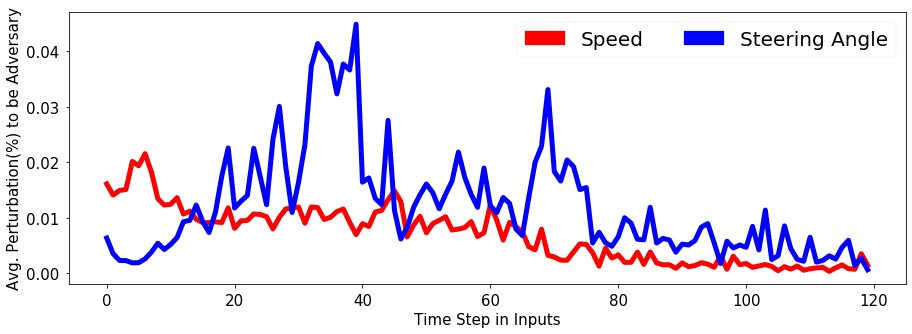

In [492]:
import matplotlib.pyplot as plt
import numpy as np
import matplotlib.patches as mpatches
plt.figure(figsize=[15,5])
plt.plot(a[0][0:120], linewidth=5, color='red')
plt.plot(a[1][:120], linewidth=5, color='blue')
plt.xlabel("Time Step in Inputs", fontsize=15)
plt.ylabel("Avg. Perturbation(%) to be Adversary", fontsize=15)
plt.xticks([0, 20, 40, 60, 80, 100, 120], [0, 20, 40, 60, 80, 100, 120], rotation=0,size=15)
plt.yticks(size=15)
labels = ["Speed","Steering Angle"]
color=['red','blue']
patches = [ mpatches.Patch(color=color[i], label="{:s}".format(labels[i]) ) for i in range(len(color)) ]
plt.legend(handles=patches, bbox_to_anchor=(1,1), ncol=2, fontsize=20)
plt.show()

```
start attacking target 18 ...

attack succeeded! with ite = 57
L2 -> L0 squeeze: L2= 19.164209847603203 , L0= 17 , epoch= 57
attack succeeded! with ite = 1
508
L2 -> L0 squeeze: L2= 18.825625118896554 , L0= 16 , epoch= 58
attack succeeded! with ite = 1
12
L2 -> L0 squeeze: L2= 18.365540902371297 , L0= 15 , epoch= 59
attack succeeded! with ite = 1
511
L2 -> L0 squeeze: L2= 17.605099200448944 , L0= 14 , epoch= 60
attack succeeded! with ite = 1
14
L2 -> L0 squeeze: L2= 17.334076983055233 , L0= 13 , epoch= 61
attack succeeded! with ite = 1
6
L2 -> L0 squeeze: L2= 17.1082039839366 , L0= 12 , epoch= 62
attack succeeded! with ite = 1
4
L2 -> L0 squeeze: L2= 16.59941399709003 , L0= 11 , epoch= 63
attack succeeded! with ite = 6
506
L2 -> L0 squeeze: L2= 17.285982051599895 , L0= 10 , epoch= 69
attack succeeded! with ite = 2
11
L2 -> L0 squeeze: L2= 17.430032095031766 , L0= 9 , epoch= 71
attack succeeded! with ite = 7
0
L2 -> L0 squeeze: L2= 18.17639049829689 , L0= 8 , epoch= 78
attack succeeded! with ite = 2
15
L2 -> L0 squeeze: L2= 18.05170958560905 , L0= 7 , epoch= 80
attack failed!
```